In [1]:
import Pkg
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("RandomMatrices")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [2]:
using Plots
using Random, LinearAlgebra
default(size=(500,280))
using Distributions
using RandomMatrices

In [3]:
mutable struct LDS
    inputDim::Int
    stateDim::Int
    outputDim::Int
    x::Array{Float64,1}
    stateCovar::Array{Float64,2}
    outputCovar::Array{Float64,2}
    A::Array{Float64,2}
    B::Array{Float64,2}
    C::Array{Float64,2}
    D::Array{Float64,2}
end

function step(lds::LDS, u::Array{Float64,1})
    #xi = if (lds.stateCovar == zeros(lds.stateDim,lds.stateDim)) zeros(lds.stateDim) else 
    #    rand(MvNormal(zeros(lds.stateDim),lds.stateCovar),1) end
    local xi
    local eta
    try
        xi = rand(MvNormal(zeros(lds.stateDim),lds.stateCovar),1)
    catch y
        xi = zeros(lds.stateDim)
    end
    #eta = if (lds.outputCovar == zeros(lds.outputDim,lds.outputDim)) zeros(lds.outputDim) else
    #    rand(MvNormal(zeros(lds.outputDim),lds.outputCovar),1) end
    try
        eta = rand(MvNormal(zeros(lds.outputDim),lds.outputCovar),1)
    catch y
        eta = zeros(lds.outputDim)
    end
    #display((lds.A,lds.x,lds.B,u,xi))
    lds.x = lds.A*lds.x + lds.B*u + xi
    lds.C*lds.x + lds.D*u + eta 
end

function ksvd(H,k)
    svdH = svd(H)
    H1 = svdH.U * Diagonal(svdH.S) * Diagonal([(if (i<=k) 1.0 else 0 end) for i in 1:size(H)[2]]) * svdH.Vt
    H1
end

function fmat(f,m,n)
    [f(i,j) for i in 1:m, j in 1:n]
end

function toep(a,b,F)
    if length(size(F))==2
        F=reshape(F,size(F)[1],1,size(F)[2])
    elseif length(size(F))==1
        F =reshape(F,size(F)[1],1,1)
    end
    #display(F)
    # starting with index 1 on diagonals
    sz = size(F)[2:end]
    #because hvcat does h first
    tiledMatrix = fmat((i,j)-> if (i<=j) F[j-i+1,:,:] else zeros(sz...) end, b, a)
    #tiledMatrix = fmat((i,j)-> if (i>=j) F[i-j+1,:,:] else zeros(sz...) end, a, b)
    #display(tiledMatrix)
    flatTiles = reshape(tiledMatrix, a*b)
    #display(flatTiles)
    TF = hvcat(b,flatTiles...)
    TF
end

function least_squares_F(l, us,Y)
    t = size(us)[1]
    U = toep(t,l+1, us)
    #display(U)
    #display(U'*U)
    #display(Y)
    MF = (U'*U) \ U'*Y
    #F = reshape(MF, )
    dy = size(Y)[2]
    du = size(us)[2]
    F = fill(0.0,l+1,dy,du)
    #display(MF)
    for i=1:l+1
        F[i,:,:]=MF[(i-1)*du+1:i*du,:]'
    end
    F
end

function collect_data(lds, T)
    us = fill(0.0,T,lds.inputDim)
    #println("us:")
    #println(us)
    Y = fill(0.0,T,lds.outputDim)
    for t=1:T
        u=rand(MvNormal(zeros(lds.inputDim),Matrix(I,lds.inputDim,lds.inputDim)))
        us[t,:]=u
        Y[t,:] = step(lds,u)
    end
    #println(us)
    return (us,Y)
end     

function hankel(m,n,F,offset=0)
    sz = size(F)
    rows = sz[2]
    cols = sz[3]
    tiledMatrix = fmat((i,j)-> F[i+j-1+offset,:,:], n,m)
    flatTiles = reshape(tiledMatrix, m*n)
    H = hvcat(n,flatTiles...)
    H
    #[f[i+j-1] for i in 1:m, j in 1:n]
end

function diag_avgs(m,n,rows,cols,A)
    cat([reshape(mean([A[(i-1)*rows+1:i*rows,(k-i-1)*cols+1:(k-i)*cols] for i in max(1,k-n):min(m,k-1)]),(1,rows,cols)) for k in 2:m+n]...,dims=1)
end

#will extract up to 3^levels
#F should be defined up to 4/3*3^levels-1
function hankel_multisvd(levels,r,F)
    Ftilde = F[1:3^levels,:,:]
    sz = size(F)[2:end]
    local Fl
    for l=1:levels
        s=2*3^(l-1)
        H=hankel(s,s,F)
        Hr=ksvd(H,r)
        #display(Hr)
        Fl=diag_avgs(s,s,sz[1],sz[2],Hr)
        Ftilde[3^(l-1)+1:3^l,:,:]=Fl[3^(l-1)+1:3^l,:,:]
    end
    Ftilde2 = Fl[1:3^levels,:,:] # 1 scale only
    Ftilde, Ftilde2
end

function fir(lds,l)
    #display([reshape(lds.C*lds.A^(t-1)*lds.B,(1,lds.outputDim,lds.inputDim)) for t=1:l])
    cat([reshape(lds.C*lds.A^(t-1)*lds.B,(1,lds.outputDim,lds.inputDim)) for t=1:l]...,dims=1)
end

function random_orth(d1,d2)
    A = rand(Haar(1),max(d1,d2))
    A[1:d1,1:d2]
end

function random_lds(d_u,d,d_y,maxEV)
    B = random_orth(d,d_u)
    C = random_orth(d_y,d)
    A = rand(MvNormal(zeros(d),Matrix(I,d,d)),d)
    vals, vecs = eigen(A,sortby=(x->-abs(x)))
    A = real.(vecs*Diagonal(vals/abs(vals[1])*maxEV) * inv(vecs))
    LDS(
        d_u, #inputDim
        d, #stateDim
        d_y, #outputDim
        zeros(d), #x
        zeros(d,d), #stateCovar
        Matrix{Float64}(I,d_y,d_y), #outputCovar
        A, #A
        B, #B
        C, #C
        zeros(d_y,d_u)) #D
end

function run_experiment_on(lds, T, lossEvery, levels, d;verbose=false,startAt=0)
    len = 4*3^(levels-1)-1
    display(len)
    (us,Y) = collect_data(lds, T)
    Ftrue = fir(lds,3^levels)
    numPts = Integer((T-startAt)/lossEvery)
    errF = fill(0.0,numPts)
    errSVD = fill(0.0,numPts)
    errMultiSVD = fill(0.0,numPts)
    local F
    local Ftilde2
    local Ftilde
    for i=1:Integer((T-startAt)/lossEvery)
        us1 = us[1:startAt+i*lossEvery,:]
        Y1 = Y[1:startAt+i*lossEvery,:]
        F = least_squares_F(len,us1,Y1)
        #display((size(F[1:3^levels,:,:]),size(Ftrue)))
        #display(F[1:3^levels,:,:]-Ftrue)
        #blah = F[1:3^levels,:,:]-Ftrue
        #display(norm(blah))
        #print(i)
        errF[i] = norm(F[1:3^levels,:,:]-Ftrue)
        #print(errF[i])
        #display(("F:",F,size(F)))
        #display(("Ftrue:",Ftrue))
        Ftilde, Ftilde2 = hankel_multisvd(levels,d,F)
        errSVD[i] = norm(Ftilde2-Ftrue)
        errMultiSVD[i] = norm(Ftilde-Ftrue)
        display((startAt+i*lossEvery, errF[i], errSVD[i], errMultiSVD[i]))
    end
    if verbose
        display("Ftrue:")
        display(Ftrue)
        display(F[1:3^levels,:,:])
        display(Ftilde2)
        display(Ftilde)
    end
    (F[1:3^levels,:,:], Ftilde2, Ftilde, errF, errSVD, errMultiSVD)
end

function run_experiment(T, lossEvery, levels, d_u, d, d_y, maxEV;verbose=false,startAt=0)
    run_experiment_on(random_lds(d_u,d,d_y,maxEV),T, lossEvery, levels, d;verbose=false,startAt=startAt)
end

function graph_experiment(lossEvery,errFs, errSVDs, errMultiSVDs;title="Error",startAt=0)
    pts = size(errFs)[2]
    errFavg = mean(errFs,dims=1)
    errSVDavg = mean(errSVDs,dims=1)
    errMultiSVDavg = mean(errMultiSVDs,dims=1)
    xs = startAt.+lossEvery*(1:pts)
    #display(xs)
    #display(errFavg)
    #display(cat(errFavg,errSVDavg,errMultiSVDavg,dims=1))
    plot(xs,cat(errFavg,errSVDavg,errMultiSVDavg,dims=1)', label = ["least squares" "SVD" "multiscale SVD"], lw=2, xlabel="time", ylabel="error", title=title)
end

function average_over_trials(d_u,d,d_y,levels,maxEV,trials,T,lossEvery;startAt=0)
    pts = Integer((T-startAt)/lossEvery)
    errFs = fill(0.0,trials,pts)
    errSVDs = fill(0.0,trials,pts)
    errMultiSVDs = fill(0.0,trials,pts)
    for trial=1:trials
        display(trial)
        (F, Ftilde2, Ftilde, errF, errSVD, errMultiSVD) = run_experiment(T, lossEvery, levels, d_u,d,d_y,maxEV, verbose=false,startAt=startAt)
        errFs[trial,:]=errF
        errSVDs[trial,:]=errSVD
        errMultiSVDs[trial,:]=errMultiSVD
    end
    (lossEvery,errFs, errSVDs, errMultiSVDs)
end

average_over_trials (generic function with 1 method)

In [4]:
Random.seed!(1)
#average_over_trials(d_u,d,d_y,levels,maxEV,trials,T,lossEvery;startAt=0)
(lossEvery,errFs, errSVDs, errMultiSVDs)=average_over_trials(1,1,1,3,0.9,10,2000,100;startAt=0)

1

35

(100, 0.6863036048176664, 0.2283582881938174, 0.21920231369168633)

(200, 0.39548807960431787, 0.19670616535292937, 0.1845482623653914)

(300, 0.31410620977607306, 0.13014353775426624, 0.14830228295000078)

(400, 0.2875478104255261, 0.10787590369826805, 0.1292562275816941)

(500, 0.2742290160449595, 0.10187624031971437, 0.12746086725914313)

(600, 0.21902756878885574, 0.12065150890370338, 0.12773932085114603)

(700, 0.21301943131304746, 0.13570670922466355, 0.14930727336508487)

(800, 0.20529600790126426, 0.11339483735169585, 0.12060238706783225)

(900, 0.20215467529519235, 0.11733713427415414, 0.11818269603379947)

(1000, 0.188020139525773, 0.11427315766046489, 0.11132040288770934)

(1100, 0.1561339058355235, 0.04731069464359403, 0.04633415806221747)

(1200, 0.15575721954042526, 0.027121148865457037, 0.03874305929214366)

(1300, 0.15895142566363246, 0.04198277653432338, 0.04740586092318646)

(1400, 0.14711330839265396, 0.03896084359241496, 0.05300950192938323)

(1500, 0.15444375012684794, 0.05445986002574805, 0.056986741512128354)

(1600, 0.14985231014506703, 0.034982063868466765, 0.043279066198626086)

(1700, 0.14188690746971194, 0.04119712700714384, 0.04434532655139374)

(1800, 0.1399072716328791, 0.03372431679675638, 0.03947981937182888)

(1900, 0.13675281180308513, 0.033306092132470676, 0.03838412977906984)

(2000, 0.13179759998582422, 0.030926873170214125, 0.04049625418780046)

2

35

(100, 0.8612039576833376, 0.3762277047120588, 0.41443525509024254)

(200, 0.48836051933967906, 0.22054799352256407, 0.30609345270264804)

(300, 0.4061397865182348, 0.10556590787887157, 0.22403942420543263)

(400, 0.3450497845103453, 0.09581133856730467, 0.2115774634509563)

(500, 0.33902315201721434, 0.06302886159695945, 0.1812540512217039)

(600, 0.313526028867615, 0.046314251884325454, 0.13967698770898326)

(700, 0.2730023984256248, 0.04883473005949706, 0.1299680536349341)

(800, 0.21878450608792263, 0.039307977897050476, 0.11466200559589614)

(900, 0.20485237130241177, 0.04021955564502743, 0.10519796600069505)

(1000, 0.18377665230580323, 0.04996096132052725, 0.1006233367959712)

(1100, 0.17556092463461023, 0.048611117880097206, 0.10137355678638568)

(1200, 0.17310552434599263, 0.04579854451814632, 0.09061759067442857)

(1300, 0.1589864595845205, 0.0476775820246388, 0.09437518061844337)

(1400, 0.14990908800953487, 0.045936139459217935, 0.0870008575610074)

(1500, 0.1508754771413973, 0.05576186719046576, 0.09221062830751243)

(1600, 0.13800973931882127, 0.05789533091704175, 0.09096027870501937)

(1700, 0.14151127109992212, 0.05266071720781716, 0.09028212357634566)

(1800, 0.1175120917898355, 0.048183490816204655, 0.07267576150207374)

(1900, 0.11129455794817375, 0.04981067087612913, 0.06520883335321054)

(2000, 0.10982359215691355, 0.04169035401581528, 0.05613320238049949)

3

35

(100, 0.620658992720308, 0.05513745473926429, 0.1858468602514265)

(200, 0.4194304792141572, 0.10495295109885402, 0.14496967812845785)

(300, 0.3606635905898483, 0.09797779659991397, 0.12943287300791645)

(400, 0.2923461893218877, 0.09371659475643308, 0.13560504554564323)

(500, 0.24254996644957083, 0.08968260788967422, 0.12889807912324264)

(600, 0.23505482703901998, 0.06603236844115092, 0.12604690837750324)

(700, 0.22930308677676267, 0.05699862762232693, 0.11484895045074776)

(800, 0.21680643600183422, 0.06782673209188175, 0.12328662815167982)

(900, 0.17911994396326397, 0.058239648819749947, 0.112306461253632)

(1000, 0.16363562152488445, 0.04819202012396955, 0.10272145966959675)

(1100, 0.1632134722760856, 0.045604882833531056, 0.10540891168048397)

(1200, 0.15922597827910787, 0.041650081475849504, 0.09653021383731798)

(1300, 0.14892874057374514, 0.03348727497330606, 0.07764770204826757)

(1400, 0.1386569924904262, 0.02785163982269362, 0.0731156332940049)

(1500, 0.13168720153579092, 0.024468651363227296, 0.060665971293489454)

(1600, 0.12283193438384661, 0.02623486234668802, 0.052117063893041445)

(1700, 0.12747823669031602, 0.02480058791684173, 0.04574534240552961)

(1800, 0.11402872149631359, 0.03140268500695182, 0.04156672886259452)

(1900, 0.1125049685902131, 0.03055263173518068, 0.04278078702372963)

(2000, 0.10969880262527822, 0.03329869212963742, 0.04609621694253513)

4

35

(100, 0.6628855845945927, 0.15327720391733776, 0.35261215652445255)

(200, 0.5522115232010321, 0.10029175923871099, 0.2668995891810129)

(300, 0.3094390142630023, 0.07573008885653251, 0.16598500391157442)

(400, 0.2545276729937768, 0.05944143543490585, 0.1048276148293007)

(500, 0.25834979996918256, 0.07416501401540178, 0.11885489279058553)

(600, 0.20507689289075723, 0.05503042732032727, 0.07181409496206667)

(700, 0.20793413982934023, 0.04549417360891665, 0.0538160480177852)

(800, 0.1764804009901985, 0.019818101921184845, 0.03491358056029631)

(900, 0.16456408228925457, 0.03542365390436146, 0.043180088792065044)

(1000, 0.13518751891326072, 0.020535394532708532, 0.03128870256695931)

(1100, 0.12202092181849734, 0.024059682910038654, 0.037986391570745376)

(1200, 0.12455862112202697, 0.02723676956310063, 0.041447941856107805)

(1300, 0.13087196066988888, 0.01396480886863278, 0.030301382941131536)

(1400, 0.11991075385172963, 0.014766660263267457, 0.03609560911054332)

(1500, 0.1256072282180251, 0.016954076101113328, 0.04027871575117137)

(1600, 0.12870773889899587, 0.019210612198994594, 0.03638684434211881)

(1700, 0.12472036807674895, 0.026200458046524325, 0.03559397197730582)

(1800, 0.12873740767702754, 0.03563350701305521, 0.03613754306578689)

(1900, 0.12728928374836354, 0.03570723407751384, 0.03871364747257786)

(2000, 0.11796939078706425, 0.031202382729878117, 0.03798399074515572)

5

35

(100, 0.7783848010631601, 0.17322486487110988, 0.2029940089416236)

(200, 0.4076085559081851, 0.041979608958360046, 0.11857291682166858)

(300, 0.31295523424413435, 0.050138700838183364, 0.13874533874376627)

(400, 0.25588127396568433, 0.04669648319641829, 0.08235432586661852)

(500, 0.19212961542299295, 0.05393507452021535, 0.09596997246514105)

(600, 0.1729290091423901, 0.048979380722878135, 0.06593580002587841)

(700, 0.1752064708761171, 0.019249736089808112, 0.044899910431454276)

(800, 0.17485324416560727, 0.017685637187031433, 0.04444997532408798)

(900, 0.1675645757373624, 0.029256555035770952, 0.057407289792853186)

(1000, 0.1551449982015589, 0.01709940668972494, 0.0438791969606289)

(1100, 0.15040772690883708, 0.010298953377903495, 0.04173580659607613)

(1200, 0.143931709293371, 0.008549292464198721, 0.022945857931154074)

(1300, 0.14182452633321632, 0.014602726655437766, 0.029912085703721152)

(1400, 0.13553872238450757, 0.017033053380775993, 0.02975057749599635)

(1500, 0.1325435737806432, 0.018049516525025545, 0.03072497638845716)

(1600, 0.12959189873090235, 0.012818349327676445, 0.026763298678099016)

(1700, 0.136502294167176, 0.02075542617200753, 0.027699686670467755)

(1800, 0.13114392059249122, 0.018893172436718262, 0.02548797595623713)

(1900, 0.1297552724707037, 0.019971717031585488, 0.023233996613867238)

(2000, 0.12933021613996187, 0.02670730279767217, 0.03020716286586359)

6

35

(100, 0.9183702575881431, 0.19040839215672262, 0.31093981707989415)

(200, 0.4548018191253689, 0.09397654058392411, 0.11728831823302953)

(300, 0.2933623410643117, 0.10462751562135021, 0.0895856920435842)

(400, 0.23618837551026886, 0.07708477861699597, 0.10493941662758892)

(500, 0.20874236247853356, 0.07604957924024246, 0.09238498816212971)

(600, 0.19326430365841718, 0.06282210009840941, 0.08611144274455072)

(700, 0.16102109856897356, 0.06451286192753164, 0.07761500129537365)

(800, 0.14693949902221892, 0.05076673995251554, 0.053407464975410074)

(900, 0.13183036778223725, 0.04391495865059963, 0.055220468015806885)

(1000, 0.12848160300386471, 0.03755175658166717, 0.041686501028958226)

(1100, 0.12236716970927912, 0.025161213408101644, 0.03835216923865076)

(1200, 0.12250038605946892, 0.020011475670440048, 0.040276792290119705)

(1300, 0.13782005959500154, 0.012681928761688742, 0.038511829963901185)

(1400, 0.13761221632409326, 0.017050074556171992, 0.028111412489647925)

(1500, 0.13404214460269556, 0.015973745035584616, 0.021278142976394486)

(1600, 0.14160374692440295, 0.018361324364751408, 0.030040755847062124)

(1700, 0.13756846021676986, 0.019154439477401555, 0.03167653692054025)

(1800, 0.13684848042184167, 0.020956783100496933, 0.027788372819343696)

(1900, 0.12394075419449822, 0.01429795947620166, 0.020094964876789998)

(2000, 0.11556224788515881, 0.011731815758403716, 0.014676704027471713)

7

35

(100, 0.5171842960179855, 0.12345315587924746, 0.2384151535789743)

(200, 0.4089904965756522, 0.09543147354188096, 0.16406430055473012)

(300, 0.316786774965848, 0.09646693140372817, 0.12502834555240142)

(400, 0.29257051705712195, 0.08016489530544196, 0.09223680867573393)

(500, 0.20358278862394677, 0.026611604888012723, 0.04531143284902452)

(600, 0.19649666395112683, 0.015712609157761407, 0.04549400628126208)

(700, 0.16147929604277456, 0.009745328363738261, 0.03265456538119739)

(800, 0.1582806106001486, 0.01866226697509917, 0.0260214871328766)

(900, 0.16344931648415464, 0.022040300633655703, 0.017367365725977007)

(1000, 0.1445768229907062, 0.022925310020600945, 0.02929522383560371)

(1100, 0.15951394135897265, 0.02127331361585748, 0.03481399218489753)

(1200, 0.1325767731963297, 0.015868641675956023, 0.02612181010852553)

(1300, 0.12196988537931984, 0.017031686886739013, 0.03449088803298364)

(1400, 0.11303095972247919, 0.022450920027270317, 0.04179798459784282)

(1500, 0.11105011268397727, 0.015321883380285799, 0.033542298057259175)

(1600, 0.11073272011720002, 0.016549254122268292, 0.03684974895795752)

(1700, 0.10819654814150147, 0.030044331992643197, 0.039728577167242846)

(1800, 0.10420173665153909, 0.02591446617045712, 0.03680665015669294)

(1900, 0.10332855043127347, 0.0289661664603122, 0.04004477617560617)

(2000, 0.10683517995896712, 0.026543257296798316, 0.04048666228806105)

8

35

(100, 0.5244913269011469, 0.20105218613119472, 0.24779742182189077)

(200, 0.3677188546358906, 0.11731580061155135, 0.1534424741323622)

(300, 0.2951988519760726, 0.11385700106725027, 0.09918824991957896)

(400, 0.29390815275039084, 0.061792109168787655, 0.10598465797098375)

(500, 0.26109364573901644, 0.06521109664677698, 0.11249015129762141)

(600, 0.19246344119037334, 0.039360125806035776, 0.06459716592340922)

(700, 0.17700592161700696, 0.019749311205921615, 0.0443894332892161)

(800, 0.16776014775368067, 0.011846499748424411, 0.04746144108471674)

(900, 0.1505037324349764, 0.020832128267466814, 0.054327174579890586)

(1000, 0.14381956785688377, 0.01924098224071152, 0.04772950473707101)

(1100, 0.13897732840475474, 0.012369780609808577, 0.02740641236770591)

(1200, 0.1417153596575992, 0.01600389211864133, 0.02089414323625276)

(1300, 0.13808362635362884, 0.029865638276260792, 0.03447014752217703)

(1400, 0.1354028881395357, 0.033225850296723855, 0.03873628514384015)

(1500, 0.128218567700683, 0.03219372053850885, 0.0372885378294869)

(1600, 0.13162783971944103, 0.021353721153712514, 0.03484412770093793)

(1700, 0.12672785767590702, 0.029152307966640416, 0.03507513565663948)

(1800, 0.12038930787829359, 0.022232763536894736, 0.03430304709495503)

(1900, 0.11957342117503636, 0.029341534426422046, 0.041571789781134814)

(2000, 0.10755804217918173, 0.04147630949961625, 0.04783296982830963)

9

35

(100, 0.4747308853725668, 0.10302675986993591, 0.11867037588298483)

(200, 0.3843793114195857, 0.08007679457684451, 0.12227214662048166)

(300, 0.3356843736727685, 0.05701132705469776, 0.08051528451963279)

(400, 0.25110208185976984, 0.07208903377568636, 0.06308508807802911)

(500, 0.2225688937365474, 0.06291829820362423, 0.04905733868112592)

(600, 0.23689459101341465, 0.07578914966154936, 0.05294623227518609)

(700, 0.20637885648732365, 0.06065223027511016, 0.039870821737370304)

(800, 0.21982459841386406, 0.06342664530583693, 0.044783800725557446)

(900, 0.20249710944631544, 0.059206664132858126, 0.04182208060298013)

(1000, 0.2032084205802292, 0.060441533264324346, 0.04519167861852219)

(1100, 0.21122699638452766, 0.05284224001389004, 0.041843470643112717)

(1200, 0.18915865303030444, 0.04868475116767, 0.03953828779217394)

(1300, 0.16403653035348573, 0.04294347568478151, 0.03183086563762589)

(1400, 0.16691735495170099, 0.04519587790908761, 0.03637565187280844)

(1500, 0.157502461130585, 0.046137494198151434, 0.03928676839957703)

(1600, 0.1479674413119238, 0.03442282854071586, 0.028470846644399663)

(1700, 0.1500651967608855, 0.01965528737220906, 0.02402721726050937)

(1800, 0.142831187949428, 0.019272635990437395, 0.022935472546938705)

(1900, 0.1416617940850091, 0.017317417205229228, 0.024989163876711167)

(2000, 0.13205224604182259, 0.017889509897556496, 0.022028812172883938)

10

35

(100, 0.5635346053162872, 0.3417805599625714, 0.29689682210869384)

(200, 0.39120296870766136, 0.14161937256410953, 0.1415543993117997)

(300, 0.26693261015537184, 0.10874227634075459, 0.11112473596879748)

(400, 0.21897887135996114, 0.08556077711357146, 0.07851303115030452)

(500, 0.2252186314081319, 0.08242284538556408, 0.07577895708537123)

(600, 0.19398915886974483, 0.07101406612369737, 0.08387161786921778)

(700, 0.22320576818012772, 0.0598847755592458, 0.09962010341433049)

(800, 0.21215512660492925, 0.04303596341964253, 0.09686717839965904)

(900, 0.19884653807119418, 0.04379655260967964, 0.10984114581683586)

(1000, 0.1922333636945384, 0.0433724888968758, 0.09573425915007662)

(1100, 0.1786308835162296, 0.05452871237488845, 0.08046743362015402)

(1200, 0.17423669692391214, 0.046023968242888076, 0.07722948985797383)

(1300, 0.15761869109781035, 0.03846998591216164, 0.06620546311211337)

(1400, 0.14567735933987433, 0.027947873455718527, 0.04929838186948528)

(1500, 0.14270856764623818, 0.03672910820934322, 0.05792274413103609)

(1600, 0.13889542224657325, 0.03991902517288595, 0.054781332438269874)

(1700, 0.13338550812983108, 0.035127577447698226, 0.0500502798279164)

(1800, 0.14040236013477092, 0.03198823337226182, 0.04990099696348575)

(1900, 0.13763019529818885, 0.031513982859679095, 0.0516563959206346)

(2000, 0.13319598685383405, 0.02869807268889084, 0.047079744930986364)

(100, [0.6863036048176664 0.39548807960431787 … 0.13675281180308513 0.13179759998582422; 0.8612039576833376 0.48836051933967906 … 0.11129455794817375 0.10982359215691355; … ; 0.4747308853725668 0.3843793114195857 … 0.1416617940850091 0.13205224604182259; 0.5635346053162872 0.39120296870766136 … 0.13763019529818885 0.13319598685383405], [0.2283582881938174 0.19670616535292937 … 0.033306092132470676 0.030926873170214125; 0.3762277047120588 0.22054799352256407 … 0.04981067087612913 0.04169035401581528; … ; 0.10302675986993591 0.08007679457684451 … 0.017317417205229228 0.017889509897556496; 0.3417805599625714 0.14161937256410953 … 0.031513982859679095 0.02869807268889084], [0.21920231369168633 0.1845482623653914 … 0.03838412977906984 0.04049625418780046; 0.41443525509024254 0.30609345270264804 … 0.06520883335321054 0.05613320238049949; … ; 0.11867037588298483 0.12227214662048166 … 0.024989163876711167 0.022028812172883938; 0.29689682210869384 0.1415543993117997 … 0.0516563959206346 0.04707

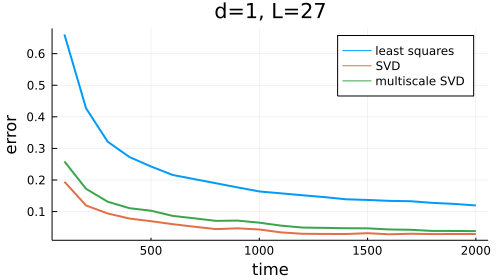

In [5]:
graph_experiment(lossEvery,errFs, errSVDs, errMultiSVDs, title="d=1, L=27")

In [6]:
savefig("lds-1-27.png")

In [19]:
Random.seed!(2)
(lossEvery,errFs, errSVDs, errMultiSVDs)=average_over_trials(3,3,3,3,0.9,10,2000,100,startAt=100)

1

35

(200, 1.522685089324084, 0.5595797387760749, 0.5336338540025656)

(300, 1.084698833229172, 0.35701216829600696, 0.38183413078704437)

(400, 0.8951334246899014, 0.29785028611830133, 0.3493755531226334)

(500, 0.7641618054983308, 0.24044706795872633, 0.28901835719980906)

(600, 0.6810446198311847, 0.21149397279025395, 0.257397652564841)

(700, 0.6246008966548489, 0.1907199911910738, 0.24033829107230262)

(800, 0.5845270774616005, 0.1782931137941158, 0.22709909793707392)

(900, 0.5482933167593786, 0.1691327453583046, 0.20746965136024093)

(1000, 0.5145503412186008, 0.15400929725485957, 0.18862625243902975)

(1100, 0.5016861242072015, 0.1560710300943358, 0.1967313960406435)

(1200, 0.48215455018356623, 0.14017574855592554, 0.18011532911895237)

(1300, 0.4596770841032786, 0.13186932044787367, 0.16360533640188388)

(1400, 0.4529615719340473, 0.13690690348267778, 0.16424129953187472)

(1500, 0.44031389048368136, 0.13886127337318993, 0.16252063734267233)

(1600, 0.42101941528447195, 0.1256382341492534, 0.15372217208862926)

(1700, 0.3958814259133285, 0.11790683754244527, 0.14441646053473056)

(1800, 0.379406567927105, 0.10131250660708636, 0.134380563839177)

(1900, 0.3603491334544584, 0.10126646366724082, 0.1299509065576907)

(2000, 0.3559491101333981, 0.10429041785555336, 0.13369142499952957)

2

35

(200, 1.7338809305486105, 1.2871900269219365, 0.5740442300446046)

(300, 1.1049071937446735, 0.29818192434746876, 0.36123249052920003)

(400, 0.8936993824887836, 0.27018853630573, 0.33107737822854066)

(500, 0.7977042011418908, 0.22818691286636159, 0.30283300134845004)

(600, 0.7128232186904191, 0.214017149566875, 0.2873166146126197)

(700, 0.6607618825342961, 0.2093228822697209, 0.2682542668279326)

(800, 0.6262358415352228, 0.2007054657644253, 0.2626844567690558)

(900, 0.6034423445810384, 0.1967966067936399, 0.2519428408835029)

(1000, 0.5819465443839061, 0.1935086540104503, 0.2455107677518996)

(1100, 0.5373346835413879, 0.1743730052497324, 0.22840112921710473)

(1200, 0.51138064472092, 0.16112091890123245, 0.21040941581945613)

(1300, 0.4848641544340882, 0.14983856184362448, 0.2028026696914672)

(1400, 0.4684384576387114, 0.14150483380774248, 0.1949987216846536)

(1500, 0.4558329810546589, 0.13545002193246694, 0.1833003149947921)

(1600, 0.43458361806569606, 0.13534249231216758, 0.18076973541538335)

(1700, 0.41439743176456617, 0.12140928909637883, 0.1664417268903382)

(1800, 0.40445044255207296, 0.1246780730363251, 0.16088294283207563)

(1900, 0.39152094174591884, 0.12350514646826087, 0.15728856358671817)

(2000, 0.3817444289625487, 0.11924992011326446, 0.15090943914713456)

3

35

(200, 1.9311458156718566, 0.6337082327401784, 0.7457140229530661)

(300, 1.2747409760900132, 0.48444617591086714, 0.5243960173625977)

(400, 1.0406993402247053, 0.4349529991638011, 0.441345564337162)

(500, 0.8855977438197499, 0.37008085014919934, 0.3807353343419471)

(600, 0.7746536990339767, 0.31119544254388554, 0.3088892010382882)

(700, 0.6965868943283349, 0.24830872486625027, 0.24993612711186777)

(800, 0.6249223550311197, 0.22224025001033462, 0.23696052774258733)

(900, 0.5745788060007354, 0.19985795656100985, 0.21267727098886907)

(1000, 0.5479992030158247, 0.21027483404411895, 0.22046042567352117)

(1100, 0.5162225365955713, 0.2127738858464656, 0.22088588718485178)

(1200, 0.4874016229794464, 0.19537639197518808, 0.20849644556810742)

(1300, 0.4709426848309918, 0.18591572860369016, 0.19449292199122278)

(1400, 0.4499393233927027, 0.16963901656084596, 0.18408199993549176)

(1500, 0.440407300804797, 0.17857921777023567, 0.1845176114375122)

(1600, 0.42271982083179577, 0.17133700605812202, 0.17613329244593073)

(1700, 0.39342168847982234, 0.15084172515487126, 0.16351913432891554)

(1800, 0.39166230023421333, 0.15492373006860882, 0.1606192362677391)

(1900, 0.38693400375717235, 0.1593410340677458, 0.16245987105487172)

(2000, 0.37641455051564415, 0.15034048039229259, 0.15198005054501798)

4

35

(200, 1.7082698765597877, 1.2261244450110518, 0.6983367823329577)

(300, 1.219457762439517, 0.513702695248783, 0.4855418756627089)

(400, 0.8448236232836693, 0.29012110720148415, 0.31562891401157633)

(500, 0.7125435897293907, 0.2643262111883579, 0.27750672705648755)

(600, 0.6669435098456069, 0.2593588041207061, 0.2711024562305585)

(700, 0.587733501036663, 0.22496174155754217, 0.23675888922326344)

(800, 0.5348061671937415, 0.18545605971685852, 0.20937135149859784)

(900, 0.5204527766693852, 0.17247335359540672, 0.197986982812343)

(1000, 0.5114874518558538, 0.16109655602488518, 0.18545710476208307)

(1100, 0.4873454438132985, 0.1591043346877893, 0.1836452545614835)

(1200, 0.48440398268354706, 0.15929313904607975, 0.17823284932703398)

(1300, 0.47948925691717764, 0.17256401192875512, 0.18657034646599407)

(1400, 0.4474639218908858, 0.16004812701832374, 0.17819728201864515)

(1500, 0.42789581419117034, 0.1588625480558127, 0.17493539081631704)

(1600, 0.40518241229722946, 0.15856160776492506, 0.16818778915095267)

(1700, 0.3919416783047583, 0.15641354736766352, 0.16624407055424545)

(1800, 0.3841216308012941, 0.15092175286951554, 0.15753931023317702)

(1900, 0.3683009055260594, 0.14087370862671456, 0.1470239917542225)

(2000, 0.3602629047355392, 0.14902565458022157, 0.15414321884679139)

5

35

(200, 1.6308126753863859, 1.0517560685041911, 0.7193820747699232)

(300, 1.0959190611738643, 0.4166787662937895, 0.43172272153705793)

(400, 0.8999020215572715, 0.3697987982452632, 0.3753650684773322)

(500, 0.7968584351783753, 0.3290120365405085, 0.3561714211750499)

(600, 0.7387867844394567, 0.303869079651488, 0.3300990406526831)

(700, 0.6835437399699508, 0.27959378086795494, 0.28476297429544967)

(800, 0.6178447547485372, 0.24575398428943213, 0.25522474654187166)

(900, 0.5483750701776772, 0.22447183324146247, 0.2301481176176428)

(1000, 0.5285424141617672, 0.20668217578873382, 0.21298742579921442)

(1100, 0.48820657132144185, 0.18991066371340706, 0.1985344516342601)

(1200, 0.4683115916883479, 0.17666634733360706, 0.18010979401167157)

(1300, 0.44885445165390153, 0.16685702828110616, 0.16847322028112963)

(1400, 0.41760899240556676, 0.13858395130126097, 0.1407577462833203)

(1500, 0.4074744253093053, 0.13051884813367448, 0.13731941429151756)

(1600, 0.40020597207413305, 0.12397368780045437, 0.13380503457449286)

(1700, 0.37517523312625073, 0.11730828078852734, 0.1276152406759837)

(1800, 0.36550513417523167, 0.11234071287318541, 0.11813792821250678)

(1900, 0.36208956866836284, 0.11496625329502999, 0.11984743193588791)

(2000, 0.3477921986840385, 0.10955772704330996, 0.11239740793401681)

6

35

(200, 1.8027065707661343, 0.7337698159791896, 0.648628811797454)

(300, 1.135676173745214, 0.37826220108109365, 0.37818447840275543)

(400, 0.9284179877019987, 0.2956489850613036, 0.31151265032503034)

(500, 0.8079521585282113, 0.2496205201554584, 0.2723031110349405)

(600, 0.7361195634504958, 0.23695470982357875, 0.2632535165418314)

(700, 0.6139481924733492, 0.2042512992482575, 0.22887846637315795)

(800, 0.6036941245605216, 0.21040084789316482, 0.22588772503048904)

(900, 0.5779721720974853, 0.1898612053438559, 0.20632771174638423)

(1000, 0.5485789863668359, 0.17768593037318042, 0.1881097112528543)

(1100, 0.5308067663776511, 0.1777894886014831, 0.19500734602589284)

(1200, 0.5086936163409251, 0.16251099805686223, 0.18934244994884178)

(1300, 0.4954417323145693, 0.1664041414555169, 0.18969228122791518)

(1400, 0.4716149516948102, 0.15801140947992634, 0.1781301906387026)

(1500, 0.4300975072858356, 0.1555479108967655, 0.1701639225875283)

(1600, 0.42078637597625124, 0.15885973139161558, 0.16983096835932565)

(1700, 0.4137505971115615, 0.15459521226348588, 0.1693815408480809)

(1800, 0.4084744950441172, 0.1526648230659821, 0.16871201978516998)

(1900, 0.39639933252160847, 0.14395228369920735, 0.1606227094221756)

(2000, 0.38366560646661396, 0.13648844873284594, 0.15725987314886394)

7

35

(200, 1.5246219279093158, 0.4180758678399052, 0.4884540602213491)

(300, 1.1594388223407819, 0.25403546712017566, 0.34059155808609315)

(400, 0.8558065594806794, 0.2199792555056693, 0.2756306973745502)

(500, 0.7421627880523481, 0.2132017744915825, 0.2599410709829146)

(600, 0.6759958386653099, 0.22572061298211765, 0.25830537216935656)

(700, 0.613977366371342, 0.21142145995871878, 0.24712459073097617)

(800, 0.5688708340709058, 0.1889240538090884, 0.22248791938021295)

(900, 0.5418761407396846, 0.16301985385696105, 0.19054305006627925)

(1000, 0.5249957899928267, 0.16555977436008557, 0.19383176134160235)

(1100, 0.5083371160446802, 0.16551477455956393, 0.19606444613390853)

(1200, 0.4779922721171995, 0.15378194669304251, 0.18008670016218228)

(1300, 0.4662672131711026, 0.16204279439072652, 0.17861173412268808)

(1400, 0.4431627692070212, 0.14327956741558334, 0.15992357091485995)

(1500, 0.42000991539799276, 0.1253974515080177, 0.14786574267462058)

(1600, 0.38945765005786626, 0.12856905425639725, 0.14589518471662571)

(1700, 0.3875562747811525, 0.1224460316281427, 0.1441966798768652)

(1800, 0.37230021331294105, 0.11444157587588351, 0.13833984844991867)

(1900, 0.351645981160215, 0.10538199165433836, 0.12874814077348226)

(2000, 0.3485446918627551, 0.10244254456509395, 0.12618347817088219)

8

35

(200, 1.6793355254350908, 1.5290607052103604, 0.7794554989786213)

(300, 1.2048592579862882, 0.601940752712102, 0.4934623762649642)

(400, 0.9506936852899864, 0.29088543184908117, 0.2925271666808327)

(500, 0.7783425494737329, 0.25732886035078306, 0.2350864377099039)

(600, 0.6839381559324872, 0.20744007744326662, 0.20816499322337795)

(700, 0.6332011088606585, 0.2028452627444595, 0.20792577675711768)

(800, 0.5777799545157194, 0.17188618434777111, 0.17413888756448712)

(900, 0.5459567646243801, 0.1642026945212709, 0.16474917598566494)

(1000, 0.5261386506126378, 0.1599044328995537, 0.16264082298723456)

(1100, 0.4922379396431679, 0.1401392037023921, 0.1507028865560141)

(1200, 0.4868629592753664, 0.1403683562655001, 0.1492782057534618)

(1300, 0.4522498666467136, 0.13624548957639201, 0.1462530068021882)

(1400, 0.4324540504285505, 0.1260508877216534, 0.136310108566234)

(1500, 0.4165539025806641, 0.13292529977969758, 0.1382650475076717)

(1600, 0.39823737724820074, 0.13807737295589545, 0.13993565840250402)

(1700, 0.38135725043836205, 0.1354514358521718, 0.14310920915646483)

(1800, 0.36709755335768796, 0.13194142741517223, 0.13996770068979447)

(1900, 0.3660442014895802, 0.1168214046359726, 0.12540474124568807)

(2000, 0.35245667214040644, 0.11611486278651922, 0.12030212608356347)

9

35

(200, 1.8496570787206175, 0.8840652825107203, 0.7602668813378836)

(300, 1.1440980340932967, 0.41750138542595794, 0.49312698790169285)

(400, 0.9198976135505172, 0.336591278749813, 0.365970681865949)

(500, 0.80270991308724, 0.24200796652502762, 0.2867242399071558)

(600, 0.7295755825735852, 0.22794594177284927, 0.2565625869450084)

(700, 0.6452385122576828, 0.2032882029290885, 0.2314224788358856)

(800, 0.6185107542955924, 0.18380183816423973, 0.2156442953287983)

(900, 0.5879606108247799, 0.18390282299607127, 0.21221056648411896)

(1000, 0.5475281510717385, 0.15824148075239675, 0.19452060551380532)

(1100, 0.5333239417980008, 0.14483302336423634, 0.18458001763563855)

(1200, 0.4903886218819667, 0.14061059238341497, 0.17072539663607436)

(1300, 0.479042139232329, 0.14301037272905862, 0.1680811576406916)

(1400, 0.453175898217653, 0.13440408832164935, 0.15126948339127297)

(1500, 0.44806890589398973, 0.13696196286256626, 0.15095632620899455)

(1600, 0.43324495503740973, 0.13995273206777778, 0.14768242693858968)

(1700, 0.4246696316916608, 0.14412558127793576, 0.1559117877572428)

(1800, 0.39956740000630697, 0.13062109510472192, 0.1479557324399181)

(1900, 0.3845167687137841, 0.12591305973286873, 0.14040962016520575)

(2000, 0.3774503608749029, 0.11924999430132818, 0.13682578274475954)

10

35

(200, 1.7908835056772943, 0.5907122796230094, 0.6571057441075185)

(300, 1.1839306092658597, 0.44437365738822837, 0.4680994425764279)

(400, 0.8841670854962035, 0.277642990455245, 0.34320372118329834)

(500, 0.7499889631033766, 0.25236187157654794, 0.28439360092499355)

(600, 0.6744563719067184, 0.23368481028246518, 0.24356260001991326)

(700, 0.6135058218193038, 0.19714574997987855, 0.21081181497239793)

(800, 0.5717550957551546, 0.19327318047104727, 0.2036573427050208)

(900, 0.5233347189663812, 0.16630189033091367, 0.1888593972955208)

(1000, 0.5073767320524829, 0.16474456106061386, 0.18880746170526747)

(1100, 0.47992530240498493, 0.14450681056699624, 0.17420673960480598)

(1200, 0.4651414705881516, 0.13232657759074656, 0.156545375855529)

(1300, 0.4443377082865892, 0.13239732590493, 0.1447995956188247)

(1400, 0.4322713153409353, 0.12950472114530306, 0.14679096938132044)

(1500, 0.4155104987655221, 0.12859542147059427, 0.14415219818593644)

(1600, 0.39956301332868893, 0.12858986351515825, 0.1440705863542474)

(1700, 0.39068152319021704, 0.1272919488790486, 0.15041119708812561)

(1800, 0.38743595312760104, 0.1297401511187814, 0.15029303595295881)

(1900, 0.37340071695160854, 0.11985610508144653, 0.14388253510075769)

(2000, 0.3614533904481458, 0.1146010640012409, 0.13646481918105036)

(100, [1.522685089324084 1.084698833229172 … 0.3603491334544584 0.3559491101333981; 1.7338809305486105 1.1049071937446735 … 0.39152094174591884 0.3817444289625487; … ; 1.8496570787206175 1.1440980340932967 … 0.3845167687137841 0.3774503608749029; 1.7908835056772943 1.1839306092658597 … 0.37340071695160854 0.3614533904481458], [0.5595797387760749 0.35701216829600696 … 0.10126646366724082 0.10429041785555336; 1.2871900269219365 0.29818192434746876 … 0.12350514646826087 0.11924992011326446; … ; 0.8840652825107203 0.41750138542595794 … 0.12591305973286873 0.11924999430132818; 0.5907122796230094 0.44437365738822837 … 0.11985610508144653 0.1146010640012409], [0.5336338540025656 0.38183413078704437 … 0.1299509065576907 0.13369142499952957; 0.5740442300446046 0.36123249052920003 … 0.15728856358671817 0.15090943914713456; … ; 0.7602668813378836 0.49312698790169285 … 0.14040962016520575 0.13682578274475954; 0.6571057441075185 0.4680994425764279 … 0.14388253510075769 0.13646481918105036])

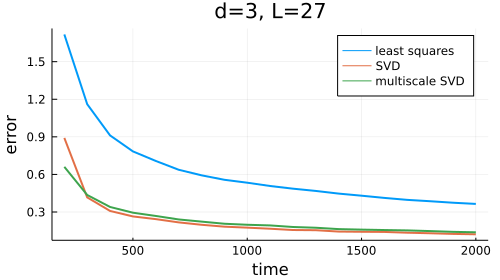

In [20]:
graph_experiment(lossEvery,errFs, errSVDs, errMultiSVDs, title="d=3, L=27",startAt=100)

In [21]:
savefig("lds-3-27.png")

In [10]:
Random.seed!(3)
(lossEvery,errFs, errSVDs, errMultiSVDs)=average_over_trials(3,3,3,4,0.95,10,2000,100,startAt=300)

1

107

(400, 3.14547602884659, 2.1203467554316986, 1.0006909692494417)

(500, 2.0650274642719366, 1.6388330171340428, 0.5775590488232085)

(600, 1.6256608454800316, 0.4552413060251124, 0.3790353666307743)

(700, 1.3905856093765532, 0.3393754562096739, 0.3443778267194819)

(800, 1.2553195644204007, 0.27947388526031797, 0.2940890425109778)

(900, 1.137347440360529, 0.2770968075610906, 0.26790371451279316)

(1000, 1.0320923686320143, 0.27886868081055244, 0.26516818081667576)

(1100, 0.9685370524983886, 0.25278173226035094, 0.24720282113476783)

(1200, 0.8967292917820654, 0.2144301664803941, 0.21478216651687293)

(1300, 0.8615649359476626, 0.18152858089627133, 0.19222566394907023)

(1400, 0.8158825756382962, 0.1699739128472402, 0.1747556892832159)

(1500, 0.7753648728763878, 0.1708551473140037, 0.1844766871540096)

(1600, 0.7669037695508699, 0.16507852746668195, 0.17723524122039647)

(1700, 0.7400369690720023, 0.15683878980431662, 0.16620907311622068)

(1800, 0.7183377266322849, 0.1508805559934602, 0.16191616306160186)

(1900, 0.6865085915507494, 0.1419797005018039, 0.15001870870375078)

(2000, 0.6605897380247994, 0.13166845544461409, 0.14269552787633433)

2

107

(400, 2.9930666439031492, 2.1581817220086825, 0.8614128303089502)

(500, 2.0168743282596786, 1.2134599219921955, 0.5090842012179111)

(600, 1.7069372487484107, 0.8726808013961262, 0.36901354841434625)

(700, 1.409259098756232, 0.3309901500003725, 0.2974841731886656)

(800, 1.2492497328359677, 0.31428961060631216, 0.2670984962924664)

(900, 1.1385221872097164, 0.2514209788228516, 0.2512113683733786)

(1000, 1.0292972212573313, 0.23918624730761673, 0.2452106007420828)

(1100, 0.9511888446476697, 0.21792572687842046, 0.22700642930455045)

(1200, 0.8968696209100794, 0.20545259668403346, 0.2013570885432573)

(1300, 0.8591677135166007, 0.19575337449206523, 0.19357452905653413)

(1400, 0.8097587607065971, 0.19616908321472848, 0.20075487401281303)

(1500, 0.7685964449259279, 0.19693966220355144, 0.19700763783726935)

(1600, 0.7277639525823784, 0.17332377363496929, 0.17842866251163314)

(1700, 0.7134186682833169, 0.17334622509936795, 0.17556795280494777)

(1800, 0.6861304332592021, 0.1594259316899309, 0.16921685159219602)

(1900, 0.6750051014787636, 0.14195409452056718, 0.15641322390801773)

(2000, 0.6590705186061002, 0.13684894267746558, 0.14918865810008172)

3

107

(400, 3.1402123788667877, 1.7247275330808234, 1.113322388392611)

(500, 2.0830842730362473, 1.54496904828186, 0.5821412598735582)

(600, 1.6649288948183834, 1.4872433287612, 0.47387808515291135)

(700, 1.4336508333711828, 1.4396309017609605, 0.4357933550373478)

(800, 1.2691989815181146, 1.4280306637005498, 0.4029209192680171)

(900, 1.1366444577377277, 1.2972779696728851, 0.33701631496786594)

(1000, 1.028847495383738, 0.9344099991429531, 0.2774018534621161)

(1100, 0.9658060549739529, 0.5806251787860899, 0.23973521153156313)

(1200, 0.9010881076430752, 0.3901117910228741, 0.19379525481761126)

(1300, 0.8544773165205362, 0.3262915577158953, 0.17823352844048562)

(1400, 0.814138407832268, 0.21210460224322353, 0.1485090934337788)

(1500, 0.7662879585936652, 0.15978405241527088, 0.14052459048664612)

(1600, 0.7326019624147393, 0.14764045817498117, 0.13035664300025915)

(1700, 0.7065830541866326, 0.14412874447962512, 0.12630664317224075)

(1800, 0.6848495643226362, 0.1294820519983749, 0.11245150819662289)

(1900, 0.6549533742689221, 0.1192310777201759, 0.11368383797300814)

(2000, 0.6353386150834918, 0.1112412913454296, 0.10588918899690297)

4

107

(400, 3.4935232380017234, 2.391060496329761, 1.194820126673724)

(500, 2.127734322495538, 0.5685024462949605, 0.46862415524951995)

(600, 1.7407837313261685, 0.4749279182276057, 0.3766329521610739)

(700, 1.4663441381313653, 0.28749633937494007, 0.3118484603978949)

(800, 1.2092155429064306, 0.2315725910773754, 0.2852586099802555)

(900, 1.0699954378669756, 0.2290340564678051, 0.2509650173442588)

(1000, 0.9791909725507628, 0.20266440206052153, 0.2292589955122998)

(1100, 0.9088639137263749, 0.1861470781842699, 0.20356985255873067)

(1200, 0.8568130085951773, 0.1755386639892766, 0.19158940208250338)

(1300, 0.8356474480700693, 0.1656196581171719, 0.19062421988270406)

(1400, 0.795225088828957, 0.15618666125322894, 0.171053871759778)

(1500, 0.7639578859716206, 0.1519060107119759, 0.1587675289541107)

(1600, 0.7216601358887123, 0.14303982137815865, 0.16011337564981806)

(1700, 0.6942269394993467, 0.13070817016229452, 0.14837299624805922)

(1800, 0.6649957593541221, 0.1134854842982823, 0.14285184302488182)

(1900, 0.6379750265876444, 0.1069512592900148, 0.13051185558567424)

(2000, 0.6236527246271881, 0.11096938878186999, 0.13100808028718536)

5

107

(400, 3.762487096895602, 2.1420308552140455, 1.3481544143106983)

(500, 2.0195787316399136, 1.735662302514476, 0.559243731383125)

(600, 1.598486927485131, 1.1888823323481044, 0.4141751489224742)

(700, 1.362516615716843, 0.28016827680084905, 0.30619446221442176)

(800, 1.2207049407693114, 0.24141919643302726, 0.2534231216882289)

(900, 1.0915352717748406, 0.1871769963578911, 0.2117491457180875)

(1000, 1.0224449267901636, 0.17687816180962865, 0.17696009357644468)

(1100, 0.9561219111574011, 0.17508350768897094, 0.1823415355761159)

(1200, 0.8847047901239794, 0.15591014525270444, 0.16588997873361616)

(1300, 0.8312358555698205, 0.14993578021233117, 0.16031232940727883)

(1400, 0.8028028345636569, 0.14428387400790074, 0.1523148901645614)

(1500, 0.7780760311881332, 0.14761905652163654, 0.15978573504107)

(1600, 0.7523254648542042, 0.1482574337498798, 0.15982021110271444)

(1700, 0.7211924935180074, 0.14674290373234747, 0.16097140056934542)

(1800, 0.6887545225174837, 0.13092567855094142, 0.14557909672677263)

(1900, 0.6711017531648068, 0.1204929744470163, 0.1374882576141158)

(2000, 0.6444614588115325, 0.11675791891898886, 0.13060205198833785)

6

107

(400, 3.710315332604086, 2.586317483701578, 1.5247916442943543)

(500, 2.037822239507426, 1.1440659242858666, 0.500092449120695)

(600, 1.5673800190143015, 1.2073869808648583, 0.38980257265983376)

(700, 1.351612633753374, 0.3590057835856484, 0.28014437311443663)

(800, 1.2332680739903052, 0.2894407303564438, 0.2632091059446382)

(900, 1.1398585292118177, 0.2669083589164434, 0.237164492309245)

(1000, 1.03310313275746, 0.20271636037455507, 0.19629728303672433)

(1100, 0.9715880247350634, 0.1841824754280529, 0.18785782245415772)

(1200, 0.9012008016230711, 0.18634743484478922, 0.1929116341555898)

(1300, 0.8600453998716635, 0.16376176982178933, 0.16710524261785253)

(1400, 0.813237284994, 0.152927154263998, 0.1618936791821935)

(1500, 0.7732884732674467, 0.1418765706847583, 0.15384144001258204)

(1600, 0.7314191154175602, 0.13337035217021664, 0.1526455022366889)

(1700, 0.7021031115943965, 0.13586274638142054, 0.1477594116727683)

(1800, 0.6792205879345469, 0.12770587255114824, 0.1415322999823281)

(1900, 0.6611090885730422, 0.1191201631950334, 0.13581489193732366)

(2000, 0.6362156164553378, 0.12063209718226388, 0.13755266448265757)

7

107

(400, 3.722667353006478, 2.770515814146466, 0.9095882892403984)

(500, 2.3202562045028725, 0.5985296463777955, 0.5388662143087792)

(600, 1.846856067802545, 0.4250909322366706, 0.44043681365671716)

(700, 1.488381284275659, 0.2590147013513372, 0.2992419225606316)

(800, 1.2419734862466323, 0.22386009165423945, 0.2604452097811366)

(900, 1.1380089124423725, 0.21672924479223563, 0.25599557881127993)

(1000, 1.0561074149614498, 0.2088788409580906, 0.24455167851336018)

(1100, 1.0006376667213177, 0.198772568648387, 0.23561773590104934)

(1200, 0.9328533829211374, 0.16898073229077115, 0.21465785068151683)

(1300, 0.8872576945817344, 0.16218019369420447, 0.20439030762605107)

(1400, 0.8281130465211629, 0.14589924365158946, 0.18375155620095812)

(1500, 0.7875250051796623, 0.13314142637263354, 0.17515342874301482)

(1600, 0.7541055608310314, 0.12937773958498897, 0.1635010051551075)

(1700, 0.7167768650226659, 0.12234397060970521, 0.1576948877657061)

(1800, 0.6749454829066185, 0.12344269881752785, 0.15108013408802634)

(1900, 0.6454720233578121, 0.11966096884917451, 0.15056717650064866)

(2000, 0.6270697884909785, 0.10947665755117804, 0.14074525775636448)

8

107

(400, 3.3373851551182305, 1.6659760104551706, 1.0373451845980202)

(500, 2.290506202631586, 1.3133396388663772, 0.5764837389317222)

(600, 1.795588042945703, 0.5876885558199193, 0.4157793157886919)

(700, 1.5841449213211314, 0.3691503034585397, 0.38475800524653614)

(800, 1.39833448258718, 0.48496103531149415, 0.3271236379061032)

(900, 1.2455309973355606, 0.25995271500697054, 0.2976503076945794)

(1000, 1.104310537097104, 0.2390173765381013, 0.26083561206751754)

(1100, 1.0262979594018335, 0.21747983193676523, 0.2351224953786033)

(1200, 0.9297153420872287, 0.21677616144190068, 0.22697559000254475)

(1300, 0.8869999224829089, 0.20663263006770025, 0.20892213757455708)

(1400, 0.8474827150291159, 0.186636169633358, 0.19506802192221648)

(1500, 0.8273763434706132, 0.19511210412355787, 0.20165479504795936)

(1600, 0.7869695727497706, 0.1722324592371798, 0.1793590131084595)

(1700, 0.7638084746101034, 0.16572459756721067, 0.1701044716033846)

(1800, 0.720633107393865, 0.16813309970345885, 0.17314987720897682)

(1900, 0.6785151983757085, 0.16688435554857925, 0.17099424256580523)

(2000, 0.6531130210138435, 0.15299019476074996, 0.1611332664265386)

9

107

(400, 3.5902486391457193, 2.5050664530829487, 1.2878905445241708)

(500, 2.469703639249736, 1.4448076742440559, 0.6249989917218116)

(600, 1.8882144941291785, 1.2402223518782314, 0.5492922492405755)

(700, 1.5962656658016738, 1.2024722257290095, 0.45476470583684425)

(800, 1.3421697690463301, 0.44895321197580135, 0.29092036443724995)

(900, 1.1348496473305762, 0.31137885360237716, 0.2326030115774629)

(1000, 1.0568005343059774, 0.21600726652199925, 0.2207981265902496)

(1100, 0.9916763628395183, 0.19116725980955576, 0.1934568116507375)

(1200, 0.9317448156550476, 0.1758587999631166, 0.17948720369722437)

(1300, 0.8973338384144011, 0.1718516370208438, 0.17401083084974595)

(1400, 0.8535395556545117, 0.1685684748036299, 0.1690130941338886)

(1500, 0.7993010882613015, 0.14464449932911538, 0.1572513812513781)

(1600, 0.7855554036452268, 0.14632282539394456, 0.1622989837499312)

(1700, 0.7404411330270162, 0.14265580262842104, 0.15968094582361114)

(1800, 0.7068565192215341, 0.13283131378943927, 0.1460666740891708)

(1900, 0.6807864958402581, 0.1347788660049833, 0.14700964600473748)

(2000, 0.6597586647904716, 0.12595153970924072, 0.14011732004143496)

10

107

(400, 3.0863917649599952, 2.2925103696412656, 0.8507819974444171)

(500, 2.1608024403999355, 0.6131937652078413, 0.4873989325998519)

(600, 1.775409508466113, 0.3717002280039231, 0.41872059389904825)

(700, 1.5108274915599826, 0.2852313025064152, 0.34127651151273286)

(800, 1.3487977368376498, 0.2673165994182482, 0.3096871006192161)

(900, 1.2168301093273886, 0.23891709785038495, 0.29282395899556823)

(1000, 1.1101746777274977, 0.23048574624662035, 0.2757123868854816)

(1100, 1.0128796608162665, 0.22800119603224142, 0.2625144128418328)

(1200, 0.9068828092838823, 0.18902682944847923, 0.21668448149970285)

(1300, 0.855974380561773, 0.16936512367533207, 0.1965184859418979)

(1400, 0.8158505826313246, 0.15931061720851977, 0.18838087934958989)

(1500, 0.7788722508320189, 0.1434396347168368, 0.17810064152097252)

(1600, 0.7510205058009071, 0.1411835406679922, 0.1809497853664078)

(1700, 0.7273841364353909, 0.13951013036775806, 0.17979595140358626)

(1800, 0.7069102106754954, 0.13645446609628228, 0.1785624568930307)

(1900, 0.6903372607811296, 0.1370697810519072, 0.1761863791193358)

(2000, 0.670742512205671, 0.14084365103629062, 0.17617544325532916)

(100, [3.14547602884659 2.0650274642719366 … 0.6865085915507494 0.6605897380247994; 2.9930666439031492 2.0168743282596786 … 0.6750051014787636 0.6590705186061002; … ; 3.5902486391457193 2.469703639249736 … 0.6807864958402581 0.6597586647904716; 3.0863917649599952 2.1608024403999355 … 0.6903372607811296 0.670742512205671], [2.1203467554316986 1.6388330171340428 … 0.1419797005018039 0.13166845544461409; 2.1581817220086825 1.2134599219921955 … 0.14195409452056718 0.13684894267746558; … ; 2.5050664530829487 1.4448076742440559 … 0.1347788660049833 0.12595153970924072; 2.2925103696412656 0.6131937652078413 … 0.1370697810519072 0.14084365103629062], [1.0006909692494417 0.5775590488232085 … 0.15001870870375078 0.14269552787633433; 0.8614128303089502 0.5090842012179111 … 0.15641322390801773 0.14918865810008172; … ; 1.2878905445241708 0.6249989917218116 … 0.14700964600473748 0.14011732004143496; 0.8507819974444171 0.4873989325998519 … 0.1761863791193358 0.17617544325532916])

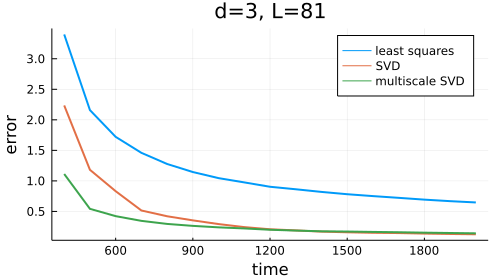

In [11]:
graph_experiment(lossEvery,errFs, errSVDs, errMultiSVDs, title="d=3, L=81",startAt=300)

In [12]:
savefig("lds-3-81.png")

In [13]:
Random.seed!(4)
(lossEvery,errFs, errSVDs, errMultiSVDs)=average_over_trials(3,5,3,4,0.95,10,2000,100,startAt=300)

1

107

(400, 3.202806470723706, 2.4420343583185264, 1.700420977172667)

(500, 1.99733429732463, 1.431582224043792, 0.7253611533602488)

(600, 1.6059197884937673, 1.0072433945816137, 0.4724092178334577)

(700, 1.4108774685719483, 1.094228672008205, 0.525970413164964)

(800, 1.2579479629659724, 0.9041796865469113, 0.3666281810483708)

(900, 1.0920556974668971, 0.9411883038279252, 0.3612529327526514)

(1000, 1.0380341761235201, 0.5717258486218995, 0.2960432296481544)

(1100, 0.9780365337966901, 0.28427290631918367, 0.25640681597417775)

(1200, 0.9135212545451373, 0.254261507178908, 0.24770080110773257)

(1300, 0.8903813720283402, 0.2596995971561628, 0.24999646167375716)

(1400, 0.8316926303121157, 0.23517146658271998, 0.2319505209899853)

(1500, 0.7881775823107122, 0.2245380154091508, 0.22262865861949602)

(1600, 0.7571814039165451, 0.21089714296131268, 0.21069031408919714)

(1700, 0.7431358735617228, 0.20182789032937087, 0.20327751430819738)

(1800, 0.7011550616182554, 0.19124023033260704, 0.1974282990411063)

(1900, 0.6760978323867454, 0.18428986880234868, 0.19393556101599232)

(2000, 0.6564684294509687, 0.1792158779475812, 0.18851642275603417)

2

107

(400, 3.1709154833982134, 1.4911374956966952, 1.1251756057985496)

(500, 2.2630139621918666, 1.333322617374043, 0.7622579462092491)

(600, 1.705345399242462, 1.1696073077399503, 0.711056394909909)

(700, 1.3762724517695466, 0.6713260916102859, 0.5170121962684915)

(800, 1.2002240533131825, 0.5722756891162399, 0.4211865746775408)

(900, 1.0971041731082274, 0.4627512403091005, 0.35678728674768573)

(1000, 1.0057403856976805, 0.3635827285507536, 0.3163257419800459)

(1100, 0.9504807662972858, 0.3699912077828704, 0.3091406323272429)

(1200, 0.8892201982662794, 0.384835010931663, 0.2925094354339017)

(1300, 0.8630469756564301, 0.43567325662751083, 0.3024481580593358)

(1400, 0.8278481212715317, 0.41375724913190726, 0.2791562856246269)

(1500, 0.8196007154959308, 0.43200466031360546, 0.29093648891789475)

(1600, 0.7884378654076016, 0.4196567077827351, 0.2703844966610455)

(1700, 0.7632711678026741, 0.4215284742279769, 0.26526204133812126)

(1800, 0.7307453637427466, 0.42674689334380655, 0.24337683331299018)

(1900, 0.6948607854839199, 0.4235044866462626, 0.23640823240817108)

(2000, 0.6728061518375679, 0.4299179485989316, 0.22237740726672361)

3

107

(400, 3.4646332157732123, 1.9612864399289838, 1.4724997079173485)

(500, 2.0640831820604357, 1.203687092608263, 0.7858499191009584)

(600, 1.662732804451413, 1.1471180739240627, 0.6221446648187512)

(700, 1.4162329830165734, 1.0267224978463771, 0.4986805762453478)

(800, 1.2575851597023582, 1.0796082625187657, 0.44173399802723695)

(900, 1.1591951737949768, 0.4185057142226966, 0.33418949174934875)

(1000, 1.0458190465458546, 0.3514915868666319, 0.2973600698295728)

(1100, 0.9886212507511851, 0.3502808287453035, 0.2662618951500581)

(1200, 0.9327180998516786, 0.33243687707470465, 0.2541938781583189)

(1300, 0.8874401674252198, 0.3344501848438996, 0.24563407476242802)

(1400, 0.8498864887855961, 0.32350487046066806, 0.23585642423481484)

(1500, 0.8196292204489888, 0.3095928428023845, 0.22481281987196594)

(1600, 0.779923280910997, 0.3020124295611303, 0.2126711998343563)

(1700, 0.7431725770519836, 0.29186094681636154, 0.20119669817007424)

(1800, 0.7138295389344231, 0.2844705413331751, 0.19854127235955357)

(1900, 0.6886928682446772, 0.27718968719704506, 0.1933416068348199)

(2000, 0.6606703836155281, 0.2736845434979305, 0.18393206272971305)

4

107

(400, 3.1034084867836143, 1.6596166126039777, 1.3381679426586532)

(500, 2.0317352701550426, 1.258788781344942, 0.8725176992589214)

(600, 1.67724168653486, 1.197896442861287, 0.7228687046531649)

(700, 1.3759946811620625, 0.8283746671184034, 0.5068245753861237)

(800, 1.2196062923807158, 0.8495523182671391, 0.47883578503407287)

(900, 1.1086244484134862, 0.461559836289781, 0.3923026893676168)

(1000, 1.0187685690952708, 0.4408744869871702, 0.37240293679206077)

(1100, 0.9513781675755555, 0.44590894272139736, 0.3537118094760704)

(1200, 0.8888270801186952, 0.4070794301833194, 0.32977794239654984)

(1300, 0.8138342679754895, 0.36865324935866356, 0.2892533038356915)

(1400, 0.7918931133533148, 0.32887876016509393, 0.26539906950253356)

(1500, 0.7500129638413915, 0.3107532824855337, 0.24779467463509497)

(1600, 0.7155901145305472, 0.3097699735691456, 0.2436399495099562)

(1700, 0.6831809264615486, 0.2897488373289841, 0.2287074968579826)

(1800, 0.6638500349252616, 0.24809872531814808, 0.20326219671151255)

(1900, 0.6433200722444705, 0.20785442573681337, 0.1949942980382836)

(2000, 0.6221617923096673, 0.19112393569045233, 0.19067179084510125)

5

107

(400, 3.786980687243694, 2.033898240234159, 1.4460815123000965)

(500, 2.4441474590832746, 1.5753020961244224, 0.9273682484098127)

(600, 1.716798652081498, 1.1349381122388653, 0.5434269212797391)

(700, 1.4503408322625748, 1.055233375883563, 0.4492322781384522)

(800, 1.3007910373807885, 0.8658332595604131, 0.39465037278530696)

(900, 1.1323170811798842, 0.7016517852375358, 0.3636630780860472)

(1000, 1.0497876861108841, 0.6206415261366925, 0.3290955960678405)

(1100, 0.97473798268415, 0.6142971392841161, 0.30800019805579215)

(1200, 0.9211445483102668, 0.6566918773534176, 0.2625458735502493)

(1300, 0.8916602707146164, 0.6388769421049216, 0.2752549705762285)

(1400, 0.8506419643597505, 0.566897149919693, 0.2492602193967091)

(1500, 0.7992583861028381, 0.5551041922284229, 0.2429544334029937)

(1600, 0.7684232971727913, 0.33752168190493126, 0.22783963111850764)

(1700, 0.7450075203025798, 0.29359669906009517, 0.2231412287950758)

(1800, 0.724219028879764, 0.2662763051782511, 0.21730043311182423)

(1900, 0.7010961582255334, 0.21093017827891888, 0.21189166803214973)

(2000, 0.6751628456928804, 0.19090285749050856, 0.19950587578878629)

6

107

(400, 3.406330180158996, 2.475753623168081, 1.5376196372544002)

(500, 2.1266272690113097, 1.7531919876546855, 0.8067232436740974)

(600, 1.7894200041190758, 0.9864520766142141, 0.6377477918365142)

(700, 1.4671582045373708, 0.45446670523613564, 0.45041320007396174)

(800, 1.3269209503203752, 0.38965792312972214, 0.40768854009789)

(900, 1.1692876849617748, 0.35372745282226004, 0.36268038681527603)

(1000, 1.0615577306632986, 0.31144932109461243, 0.32376391495400775)

(1100, 0.9959773475948658, 0.28226357980238215, 0.29169091628279675)

(1200, 0.9309458991812335, 0.27487606134951714, 0.2820904002799861)

(1300, 0.8849751539865397, 0.2655373055344457, 0.2726700625599496)

(1400, 0.8425786464256649, 0.242448574740408, 0.2557080400525412)

(1500, 0.804802057936836, 0.23368053492389046, 0.2380700215446018)

(1600, 0.7608398553696613, 0.2200335726032712, 0.22279440256973954)

(1700, 0.7209483374369303, 0.20903786210856343, 0.2147636601996325)

(1800, 0.6964700048159319, 0.19950377519811796, 0.20541649356812866)

(1900, 0.6751333133610351, 0.1943185925885929, 0.20178827395183627)

(2000, 0.6423612212875003, 0.18309875213627122, 0.19105667075402707)

7

107

(400, 3.7156348065724347, 2.3140494287778277, 1.657554434134844)

(500, 2.2144859877016976, 0.9250203574342726, 0.6875292799208625)

(600, 1.7398955114313193, 0.8841540758319315, 0.5520591890388736)

(700, 1.4846163656100846, 0.5855622323273327, 0.43630890757457597)

(800, 1.2457453786414447, 0.428109928987387, 0.3614804445213613)

(900, 1.1694996312545984, 0.539122518515022, 0.368249834336953)

(1000, 1.0763066529018348, 0.35682902317277077, 0.32926870037124295)

(1100, 1.0135320928683593, 0.3017715218838543, 0.3164399383958433)

(1200, 0.9502187380718308, 0.2490680195049132, 0.27964399048517485)

(1300, 0.9101529270873203, 0.2572458900246072, 0.26153661128321903)

(1400, 0.8728481920320866, 0.2554124257216677, 0.26248890689254784)

(1500, 0.8119759960677626, 0.2381996343179625, 0.25446650718272357)

(1600, 0.7554302152740892, 0.21868891568026555, 0.24198457047833247)

(1700, 0.7299483032799124, 0.2130103814592049, 0.2365349782302019)

(1800, 0.7035026224853731, 0.1965154234996093, 0.22537623432159487)

(1900, 0.6656381552841739, 0.17683700017709464, 0.2047984777147264)

(2000, 0.6399204760870134, 0.16631432897617998, 0.1945503214575279)

8

107

(400, 3.1118175174887353, 2.2687400995728555, 0.8832625742627055)

(500, 2.0777470179833806, 1.1771901110330418, 0.5971260187885935)

(600, 1.5842281047706837, 0.4257292702782109, 0.4101373705294503)

(700, 1.3768571315602027, 0.3582737261395376, 0.34573614750835185)

(800, 1.2480767718841403, 0.3265628777544206, 0.33436577751643526)

(900, 1.1531149534447556, 0.295360581872565, 0.32733667874643935)

(1000, 1.052395901892394, 0.26577267958339357, 0.2943635278511372)

(1100, 0.9633339413420938, 0.2573550835686871, 0.27349129717764475)

(1200, 0.8811586903046446, 0.22052428743841787, 0.23911410216574638)

(1300, 0.8715494657746709, 0.2277227032294079, 0.24135977539172204)

(1400, 0.8396632925832246, 0.22521229896223063, 0.2408839750082907)

(1500, 0.8080478163026268, 0.21556910376253766, 0.2248696660073411)

(1600, 0.7664334444295521, 0.1888385848539289, 0.20841672534078798)

(1700, 0.7445618259507283, 0.18562719483209955, 0.20515010656404953)

(1800, 0.7161645739952847, 0.16202136175079285, 0.18574476443324028)

(1900, 0.6916791833307298, 0.1618458156559952, 0.18500963350271904)

(2000, 0.6735326062246285, 0.16775546308930137, 0.1871360849417573)

9

107

(400, 3.342691979350366, 1.8576313249149907, 1.419922711402614)

(500, 2.3299268347698012, 1.6557218509013916, 0.8661835032655829)

(600, 1.7177381903398075, 0.8982895576070576, 0.5926870269567229)

(700, 1.5393602628157879, 0.8101054447139812, 0.4871749756550893)

(800, 1.314267846386617, 0.7014245651678372, 0.4075579501509505)

(900, 1.1613253662952647, 0.4918783639508836, 0.3711595125630146)

(1000, 1.0853367578799005, 0.4109320159639594, 0.3373073096510741)

(1100, 1.0307399611067976, 0.4873655481557525, 0.34684212625981814)

(1200, 0.9610302780482095, 0.33655183546728196, 0.30894433891284556)

(1300, 0.8836869636896642, 0.26921723082509685, 0.2844699479498943)

(1400, 0.853372986907366, 0.2739110587379902, 0.30030336813902625)

(1500, 0.8122723391828771, 0.26633115055534357, 0.3017362998251338)

(1600, 0.7813632680919494, 0.25319436539506956, 0.28462725550127077)

(1700, 0.7399010187773164, 0.22895095988749112, 0.24408587570166165)

(1800, 0.7201059556711997, 0.22451806496675397, 0.24846930767399156)

(1900, 0.6969961686821657, 0.22115439357094846, 0.2425486714121607)

(2000, 0.6741332461893333, 0.21642240971307905, 0.23081298427389593)

10

107

(400, 3.5505504679499666, 2.028652751033057, 1.733448504585137)

(500, 2.3856480125321857, 1.6362284889558643, 0.9223993587799945)

(600, 1.8675491795951373, 1.50911375668849, 0.7021081288876551)

(700, 1.5402076906037028, 1.085421770132375, 0.4736084209050845)

(800, 1.3594937328439642, 0.8734349702704072, 0.4308518225168629)

(900, 1.2281949098307083, 0.5337244266775708, 0.3232699694243586)

(1000, 1.1122924691858138, 0.3507635862703749, 0.2970609003369762)

(1100, 1.029828863521839, 0.2840910098740958, 0.2937924563131569)

(1200, 0.9444566475069053, 0.27633928664921303, 0.27262157464494685)

(1300, 0.8894967882947493, 0.26987701101987993, 0.265353044609778)

(1400, 0.8326523812840447, 0.25067289542332033, 0.24273410608219678)

(1500, 0.803528724787914, 0.24074317854483623, 0.23906853332611622)

(1600, 0.7724348783895052, 0.20754213291567067, 0.23111422727484293)

(1700, 0.7347657036347872, 0.21152721322625734, 0.2282782312790067)

(1800, 0.6963161901046225, 0.19564877840735426, 0.20378915553947202)

(1900, 0.6728852049894322, 0.1917797022043353, 0.19944605870831306)

(2000, 0.6534251825009064, 0.1959024440557391, 0.20789560021497394)

(100, [3.202806470723706 1.99733429732463 … 0.6760978323867454 0.6564684294509687; 3.1709154833982134 2.2630139621918666 … 0.6948607854839199 0.6728061518375679; … ; 3.342691979350366 2.3299268347698012 … 0.6969961686821657 0.6741332461893333; 3.5505504679499666 2.3856480125321857 … 0.6728852049894322 0.6534251825009064], [2.4420343583185264 1.431582224043792 … 0.18428986880234868 0.1792158779475812; 1.4911374956966952 1.333322617374043 … 0.4235044866462626 0.4299179485989316; … ; 1.8576313249149907 1.6557218509013916 … 0.22115439357094846 0.21642240971307905; 2.028652751033057 1.6362284889558643 … 0.1917797022043353 0.1959024440557391], [1.700420977172667 0.7253611533602488 … 0.19393556101599232 0.18851642275603417; 1.1251756057985496 0.7622579462092491 … 0.23640823240817108 0.22237740726672361; … ; 1.419922711402614 0.8661835032655829 … 0.2425486714121607 0.23081298427389593; 1.733448504585137 0.9223993587799945 … 0.19944605870831306 0.20789560021497394])

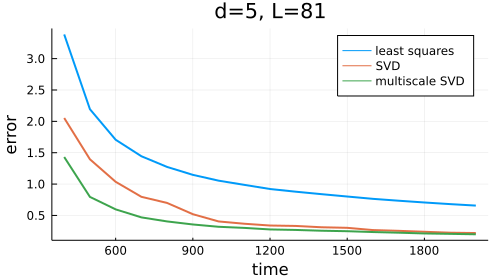

In [14]:
graph_experiment(lossEvery,errFs, errSVDs, errMultiSVDs, title="d=5, L=81",startAt=300)

In [15]:
savefig("lds-5-81.png")

In [25]:
Random.seed!(5)
(lossEvery,errFs, errSVDs, errMultiSVDs)=average_over_trials(3,10,3,4,0.95,10,2000,100,startAt=300)

1

107

(400, 3.6462980572463657, 2.523551873502674, 2.3843604515038006)

(500, 2.2950895399175306, 1.3969884966000472, 1.2841815739306504)

(600, 1.6165584943868372, 0.8409236129084185, 0.7980381207570266)

(700, 1.4219175187902984, 0.7618577921157693, 0.6904757165184299)

(800, 1.3053722898704836, 0.7633446055209813, 0.7021699107109249)

(900, 1.2159835675096589, 0.8112046145405513, 0.6618664886530635)

(1000, 1.0936751240053162, 0.7608006996711651, 0.5950047773269663)

(1100, 1.0286892297286776, 0.7136660123869322, 0.5623411894057108)

(1200, 0.9514759337564086, 0.69786673685871, 0.5123632203675694)

(1300, 0.8904074468103735, 0.597803707304813, 0.4733803051799999)

(1400, 0.8291010475969585, 0.5233241438430515, 0.43982862507344656)

(1500, 0.7842873469093111, 0.43618800810033626, 0.39255113093843125)

(1600, 0.7519420002859988, 0.3751396241315338, 0.36330104951748304)

(1700, 0.716412527669026, 0.363857455255187, 0.33061380371785115)

(1800, 0.6798999427472974, 0.3450274551453519, 0.32335451806230964)

(1900, 0.6569477618247449, 0.3118250610279192, 0.31278130836051593)

(2000, 0.6517760540359914, 0.308678628672428, 0.3114368779554675)

2

107

(400, 3.735153491836088, 2.5572704889687703, 2.313113009639411)

(500, 2.4392558491012077, 1.771832029472171, 1.393939470062565)

(600, 1.684125461682471, 0.9821247103037725, 0.9357243599209719)

(700, 1.3528880952046876, 0.7201229047971212, 0.674134872434184)

(800, 1.2097038738224852, 0.6995337097820531, 0.616831193069151)

(900, 1.1293813200719531, 0.6517885220298593, 0.5691646450197346)

(1000, 1.0418960391189096, 0.5699186605141223, 0.5179772171343822)

(1100, 1.0226522395313542, 0.5370644969771337, 0.48851591887546597)

(1200, 0.985439007817426, 0.5453329405808965, 0.4777567644116474)

(1300, 0.9365619058552886, 0.47348686214713476, 0.44041133643841623)

(1400, 0.8833078785926264, 0.42305321565784915, 0.4197917222396898)

(1500, 0.8221696443353118, 0.4082346176270685, 0.38641136507500307)

(1600, 0.7888089659029094, 0.37037154892554325, 0.37946091736038706)

(1700, 0.7419106019254779, 0.3583904462652985, 0.3606175607812683)

(1800, 0.7135572075695736, 0.3291681954254708, 0.3320400407570628)

(1900, 0.6934451754320651, 0.33284841593273795, 0.3288075743989481)

(2000, 0.6682390537618671, 0.3345353880251571, 0.32643305508711323)

3

107

(400, 4.112749525412487, 2.73957982418598, 2.7829942077656367)

(500, 2.2422089685751394, 1.4171818171393118, 1.2668440575037034)

(600, 1.703989672597448, 1.0163065631589714, 0.8915367725904765)

(700, 1.4658685884835585, 0.8166281964002063, 0.776446196634438)

(800, 1.341793901942535, 0.7334994015441227, 0.7168203774347451)

(900, 1.1719307786853352, 0.5643584787905029, 0.5364052009595444)

(1000, 1.0563601721722187, 0.47218542585841117, 0.4680169320209131)

(1100, 1.0023092829069553, 0.43658223812727326, 0.4407212741952434)

(1200, 0.9193668539031727, 0.42334848086010324, 0.40974868647832746)

(1300, 0.8698223289836932, 0.4062686007274035, 0.37244567174735255)

(1400, 0.8467100092721851, 0.3888325695385435, 0.3613353720182535)

(1500, 0.8153061578984815, 0.3722730090454894, 0.3415639704474031)

(1600, 0.7915955810743279, 0.3710659568181416, 0.33066663278978087)

(1700, 0.7554722258767413, 0.3616932053244621, 0.32061634441523956)

(1800, 0.7306764849009674, 0.34042100619971244, 0.30770864655346486)

(1900, 0.6946652574654012, 0.3657175815820594, 0.3153847365157113)

(2000, 0.6818798278732218, 0.3538404702787658, 0.3009622570644184)

4

107

(400, 3.1129366032697035, 1.6177321237326878, 1.4291734127130327)

(500, 2.2512306292271997, 1.1593132540671842, 1.0716086425428266)

(600, 1.7010054930384602, 0.7230238444486274, 0.7836844637722191)

(700, 1.4178800261531657, 0.5564721906427832, 0.6136575673934246)

(800, 1.241380205989969, 0.464974255883254, 0.4859927178015283)

(900, 1.1359399316204908, 0.4316462227526608, 0.48309283363318034)

(1000, 1.0598893930497402, 0.4187680641691405, 0.44070930566738825)

(1100, 0.9919182192414349, 0.3976691163544172, 0.410400965940083)

(1200, 0.9446223331609892, 0.37721309462059643, 0.395147174635185)

(1300, 0.8922605343376687, 0.3490546187896898, 0.36406245861846354)

(1400, 0.8420715872491288, 0.33163850060853295, 0.34521452302928163)

(1500, 0.8154039548585791, 0.32343891879990855, 0.33750205708432224)

(1600, 0.772789868704594, 0.30897955625732887, 0.31914025446137956)

(1700, 0.744806832978273, 0.2984059951889903, 0.31578394809375604)

(1800, 0.727893958675577, 0.2929727337409504, 0.3069582267036286)

(1900, 0.708056734973316, 0.2831523879847712, 0.2945504620354319)

(2000, 0.6766882382623978, 0.2750148698857833, 0.2805812640250674)

5

107

(400, 3.8379983400764344, 2.542687759429999, 2.392353972827173)

(500, 2.4450879294222405, 1.7784472128114526, 1.4113379148100669)

(600, 1.871893262430935, 1.3759255047478591, 1.036139716685118)

(700, 1.5349391338004013, 1.1223674320387542, 0.8246000195558418)

(800, 1.3071860236480572, 0.7452563616243355, 0.6546216054628428)

(900, 1.16602927742344, 0.6451235518130802, 0.5833624626538096)

(1000, 1.103011641646774, 0.5581464369893854, 0.5331323234681311)

(1100, 1.0313185621064127, 0.49820362464597095, 0.47885246159947586)

(1200, 0.9271442588633605, 0.4170543039950269, 0.42111484697923635)

(1300, 0.8862592389309889, 0.3941948526775014, 0.39965734596521285)

(1400, 0.8352150132057157, 0.3846047375204383, 0.38353727124043396)

(1500, 0.8006987925618131, 0.3562001265389124, 0.37398158607088505)

(1600, 0.7575106306957271, 0.34744269838870995, 0.3563391641350325)

(1700, 0.7211563794284747, 0.31549245749676724, 0.32669232346825033)

(1800, 0.688997640394468, 0.3015825235079876, 0.3123117957170163)

(1900, 0.6668300302917984, 0.2841921183546309, 0.29807113783721634)

(2000, 0.6439353027816299, 0.2681064523929817, 0.29074033009061195)

6

107

(400, 3.5817949175193284, 2.5599234807148887, 2.388106982740335)

(500, 2.118231709090324, 1.421347146285287, 1.2610387605298767)

(600, 1.7414215607625962, 1.131575554719108, 0.959658514757103)

(700, 1.476016433499136, 1.008812612488822, 0.7975023708140535)

(800, 1.318258925163851, 0.9402367106912843, 0.6830483954378791)

(900, 1.171445551324849, 0.7822251711352821, 0.5775008000713413)

(1000, 1.050575995229226, 0.5750333977309731, 0.4954317631034519)

(1100, 0.9724075691188173, 0.5400137003658882, 0.4462783421570202)

(1200, 0.9060663234409818, 0.4919125330248703, 0.4194362808186572)

(1300, 0.8435917772532487, 0.4431468573059523, 0.40505575079887085)

(1400, 0.8095950845674349, 0.42142018809620535, 0.4036808051673293)

(1500, 0.7766713590269679, 0.37528670313311474, 0.37141573974916314)

(1600, 0.7684375242607745, 0.36760440821242746, 0.3749608892306278)

(1700, 0.746099280828485, 0.3825299743489779, 0.3628543041486032)

(1800, 0.7146288270274702, 0.3570227037139246, 0.34657817353334186)

(1900, 0.6693921136515704, 0.3430213368027676, 0.3308288385391493)

(2000, 0.6423711964361439, 0.3221906250226003, 0.31249804595848235)

7

107

(400, 3.179713106704725, 1.829557742586236, 1.8127507832444023)

(500, 2.294392852308223, 1.3839075650802803, 1.3098160272445285)

(600, 1.7193369672448982, 1.1412246453728894, 0.9134829989470424)

(700, 1.4719630232961822, 0.920729155078245, 0.7725473502572638)

(800, 1.3055767288716684, 0.7075456017526245, 0.619526910332549)

(900, 1.1797344021135134, 0.6540324934849835, 0.5636993703724577)

(1000, 1.0887995256439407, 0.6636401407509261, 0.5360912740295094)

(1100, 0.9932108473113257, 0.6078070142264101, 0.4754496143278312)

(1200, 0.9508997564796123, 0.5864648875905984, 0.44494825810086563)

(1300, 0.9014585609020052, 0.5001775932632528, 0.3961681296716353)

(1400, 0.8559416842627232, 0.5294156384811878, 0.3691933117926716)

(1500, 0.8243696399480229, 0.4894575761100625, 0.35209314433459926)

(1600, 0.77904625164228, 0.42660127215660765, 0.3204003984376592)

(1700, 0.748081513404228, 0.37442936347990513, 0.31171319409915144)

(1800, 0.7156879283964741, 0.37613349918454636, 0.29240150223070677)

(1900, 0.6837514277492113, 0.38704040762197467, 0.2895751738027846)

(2000, 0.6689904824484806, 0.36407113325948276, 0.2882166025574359)

8

107

(400, 3.581950818694508, 2.3220067502307553, 2.0550470118157094)

(500, 2.1444686041277503, 1.48560867033698, 1.1806777324808952)

(600, 1.6122534057106201, 1.0310019895517732, 0.8092253695708498)

(700, 1.417079185290337, 0.9097883272266832, 0.6566362424234521)

(800, 1.2448791486278148, 0.7054060811457482, 0.5611717063973226)

(900, 1.119612078221322, 0.6519252567411294, 0.5087509797995048)

(1000, 1.0469675313629496, 0.6190945410475335, 0.4682094387256692)

(1100, 0.9728334805989067, 0.6027199999228756, 0.4503312831068854)

(1200, 0.8890876986826677, 0.5408564743606933, 0.4173011853317996)

(1300, 0.8404540432866004, 0.4928048985853137, 0.37684191421233054)

(1400, 0.7924688453503331, 0.3619500474556451, 0.34176612770358555)

(1500, 0.7600842760570105, 0.38633894904329713, 0.33421875833066655)

(1600, 0.7392670414395248, 0.32051575038377117, 0.3129221923544152)

(1700, 0.7105882102215971, 0.30052471940872827, 0.29809546239234763)

(1800, 0.6779243475138651, 0.27752025769057387, 0.2857049222070514)

(1900, 0.6659955514932248, 0.276294692387548, 0.2839692853049139)

(2000, 0.6582831968003034, 0.2727875034761649, 0.27940028666225364)

9

107

(400, 3.115142712954285, 1.9032654745618711, 1.7792476315152626)

(500, 2.284479408344356, 1.4605709998489, 1.2691135643351716)

(600, 1.710415809656823, 1.1124548657178783, 0.8674202901380837)

(700, 1.4095506091520986, 0.8810943012280203, 0.6578515833369748)

(800, 1.22484985232347, 0.6604440380980992, 0.5671379144475875)

(900, 1.1082028473733385, 0.5595200007996961, 0.5153871512372795)

(1000, 1.0718428223439291, 0.5511697113146357, 0.5194254492729099)

(1100, 0.9869485601138775, 0.466220510570216, 0.444344604971771)

(1200, 0.9289656109729054, 0.42678818671918184, 0.4143927059800678)

(1300, 0.8826614949951128, 0.3885409701996136, 0.3861272992756989)

(1400, 0.8289783292453703, 0.37967580558515945, 0.36458348093921816)

(1500, 0.7949573442846383, 0.390241710294005, 0.35281352264858495)

(1600, 0.7596371278779365, 0.3684683722838436, 0.3383287087574922)

(1700, 0.7295674634042205, 0.3410423581147201, 0.32040988958328354)

(1800, 0.7087554404305968, 0.3564413956689325, 0.319982432665515)

(1900, 0.6807141879092029, 0.3442998804556149, 0.29784612318271025)

(2000, 0.6570638345077036, 0.30410684915093544, 0.28381500448635183)

10

107

(400, 3.1295745990202177, 1.8795753755520976, 1.7321425526179508)

(500, 2.124792973816694, 1.3971699112451108, 1.164790341367345)

(600, 1.7101574531133463, 0.8803069336074485, 0.8296092368962392)

(700, 1.4460370557087994, 0.7291704642157508, 0.7209273414928778)

(800, 1.2704881859473587, 0.689102786578974, 0.6289869987499193)

(900, 1.1747458033929388, 0.625223426904941, 0.5677262762761892)

(1000, 1.0639489662009434, 0.5107566221794523, 0.47266832772858247)

(1100, 0.977248672684297, 0.48889807730590534, 0.40623385712765187)

(1200, 0.909998130444745, 0.4988912251998674, 0.40627575175305086)

(1300, 0.8477324515912207, 0.399564717728426, 0.35664424994018207)

(1400, 0.8138661494026256, 0.3971712791315099, 0.367529667549909)

(1500, 0.7830357718035538, 0.3783873731450752, 0.36509557638945817)

(1600, 0.7616846532142573, 0.35958445504510433, 0.350536070735071)

(1700, 0.742112380965967, 0.34602738029352464, 0.33351900016543934)

(1800, 0.7233126989189956, 0.3409243435837932, 0.33036710035863925)

(1900, 0.7093570198324797, 0.29780522046466745, 0.3044328876860355)

(2000, 0.6919984107082549, 0.3206327938985959, 0.3196986480732637)

(100, [3.6462980572463657 2.2950895399175306 … 0.6569477618247449 0.6517760540359914; 3.735153491836088 2.4392558491012077 … 0.6934451754320651 0.6682390537618671; … ; 3.115142712954285 2.284479408344356 … 0.6807141879092029 0.6570638345077036; 3.1295745990202177 2.124792973816694 … 0.7093570198324797 0.6919984107082549], [2.523551873502674 1.3969884966000472 … 0.3118250610279192 0.308678628672428; 2.5572704889687703 1.771832029472171 … 0.33284841593273795 0.3345353880251571; … ; 1.9032654745618711 1.4605709998489 … 0.3442998804556149 0.30410684915093544; 1.8795753755520976 1.3971699112451108 … 0.29780522046466745 0.3206327938985959], [2.3843604515038006 1.2841815739306504 … 0.31278130836051593 0.3114368779554675; 2.313113009639411 1.393939470062565 … 0.3288075743989481 0.32643305508711323; … ; 1.7792476315152626 1.2691135643351716 … 0.29784612318271025 0.28381500448635183; 1.7321425526179508 1.164790341367345 … 0.3044328876860355 0.3196986480732637])

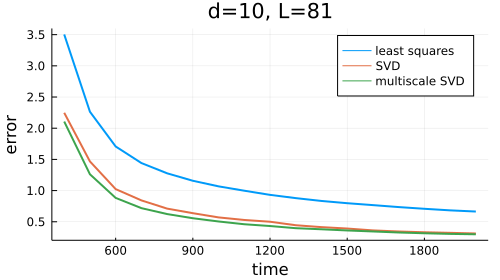

In [26]:
graph_experiment(lossEvery,errFs, errSVDs, errMultiSVDs, title="d=10, L=81",startAt=300)

In [27]:
savefig("lds-10-81.png")

In [41]:
Random.seed!(6)

trials=1
T=2000
lossEvery=100
startAt=300
pts = Integer((T-startAt)/lossEvery)
errFs = fill(0.0,trials,pts)
errSVDs = fill(0.0,trials,pts)
errMultiSVDs = fill(0.0,trials,pts)
d=3
d_y=3
d_u=3
for trial=1:trials
    display(trial)
    lds = LDS(
        3, #inputDim
        3, #stateDim
        3, #outputDim
        zeros(d), #x
        zeros(d,d), #stateCovar
        Matrix{Float64}(I,d_y,d_y), #outputCovar
        Diagonal([.95,-.8,-.5]), #A
        Diagonal([1.0,1.0,1.0]), #B
        Diagonal([1.0,1.0,1.0]), #C
        zeros(d_y,d_u)) #D
    (F, Ftilde2, Ftilde, errF, errSVD, errMultiSVD) = run_experiment_on(lds,T, lossEvery, 4, 5,startAt=startAt)
    errFs[trial,:]=errF
    errSVDs[trial,:]=errSVD
    errMultiSVDs[trial,:]=errMultiSVD
end


1

107

(400, 3.6791869224685745, 2.729862094626959, 1.9128096339225216)

(500, 2.339119294665248, 1.3733123745239553, 0.8734391226721557)

(600, 1.7336790922921255, 0.7855135982608649, 0.5909723709626481)

(700, 1.4064428286900235, 0.4699483586242868, 0.4923973110778161)

(800, 1.2544649242524437, 0.4168225396969642, 0.42988347429306756)

(900, 1.1314170474611451, 0.3811444742436204, 0.3953274741632258)

(1000, 1.039234112337101, 0.2983680077458322, 0.3552623212596464)

(1100, 0.9988375977813676, 0.3190273713998962, 0.36824622302938775)

(1200, 0.926953976161559, 0.294222624154357, 0.34045399353233463)

(1300, 0.8684778826067736, 0.26835923463472544, 0.30866746606659146)

(1400, 0.847673187269697, 0.26463710470077895, 0.3062554548970445)

(1500, 0.8055228827816573, 0.23371146810569857, 0.283242843458023)

(1600, 0.7706515459230602, 0.2139945333923716, 0.2510377541695587)

(1700, 0.7437729339098414, 0.20902942478323355, 0.24719290875673594)

(1800, 0.7156466598755501, 0.21829866942060294, 0.24470653653166047)

(1900, 0.6936767245820314, 0.22548698844963108, 0.24726123376069598)

(2000, 0.6813412726187102, 0.2227907366583847, 0.2505115828616688)

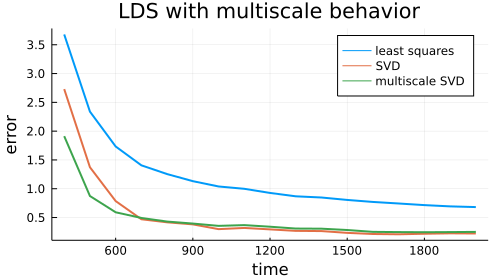

In [42]:
graph_experiment(lossEvery,errFs, errSVDs, errMultiSVDs, title="LDS with multiscale behavior",startAt=300)

In [43]:
Random.seed!(1)
#average_over_trials(d_u,d,d_y,levels,maxEV,trials,T,lossEvery;startAt=0)
(lossEvery,errFs, errSVDs, errMultiSVDs)=average_over_trials(1,1,1,4,0.95,10,2000,100;startAt=300)

1

107

(400, 0.530641244834892, 0.1382141256367587, 0.13731520915613898)

(500, 0.47941294412807833, 0.1295911554663025, 0.13237089508122515)

(600, 0.4465835891379843, 0.12937090944988003, 0.11337713516989006)

(700, 0.3940627955733579, 0.14454646928288137, 0.13115084106208513)

(800, 0.3702012016372823, 0.11663190205312912, 0.10158573504254577)

(900, 0.36260877882425113, 0.1283045475323472, 0.10419674954546276)

(1000, 0.33236277579470985, 0.12645473310547523, 0.10329571015581525)

(1100, 0.29867790119449966, 0.06846446179559142, 0.055002195113667086)

(1200, 0.28211720315632255, 0.05377561165048357, 0.05182065846233108)

(1300, 0.26633832852272793, 0.06098409504851389, 0.06135266382693288)

(1400, 0.24551394537106216, 0.054292021683100954, 0.05999240618622095)

(1500, 0.24312506866345715, 0.0549722877150695, 0.06299352569385536)

(1600, 0.22968719726204762, 0.05352975800537178, 0.0570904297904132)

(1700, 0.22467925786974283, 0.05727819697476161, 0.05876876514262529)

(1800, 0.21674218003100085, 0.05856713844375932, 0.05985475710732728)

(1900, 0.21274778634513217, 0.05512338142208359, 0.056699654424368105)

(2000, 0.20469918091755196, 0.05726087713958733, 0.0594796299588024)

2

107

(400, 0.5748121109870966, 0.08780884547697791, 0.18975741572870808)

(500, 0.5211927595967649, 0.0790680176508972, 0.16617852835305955)

(600, 0.4695722260397009, 0.0587225515336086, 0.12512012751566012)

(700, 0.4130730450667213, 0.025122942860296947, 0.11711965306388945)

(800, 0.33575059983028066, 0.02295135724338187, 0.11135328354917796)

(900, 0.306425768146985, 0.024135984920621866, 0.09772624612951361)

(1000, 0.28325935397208796, 0.03098471731646763, 0.09412515390613474)

(1100, 0.27734035940062873, 0.036715613491228774, 0.09527973750610347)

(1200, 0.26603779357396207, 0.034334294532007585, 0.09003341563125046)

(1300, 0.24971026366295862, 0.03302946535287512, 0.09698235801958627)

(1400, 0.24866509217405472, 0.030501318519851696, 0.09236995033522857)

(1500, 0.25229813861346895, 0.03473815815472506, 0.09687230339383979)

(1600, 0.23702165251952084, 0.036389653564327586, 0.09569052370998898)

(1700, 0.22880891732324218, 0.034166545660838384, 0.09767561741604233)

(1800, 0.2110249716890123, 0.03399689970421908, 0.07776613186992884)

(1900, 0.2049900877874923, 0.03185793892396914, 0.06966250196863755)

(2000, 0.20442636049044396, 0.028265009963434336, 0.05980148264046849)

3

107

(400, 0.5855727664660849, 0.10923108892176142, 0.1503188518880173)

(500, 0.4611668657850955, 0.06196364771345835, 0.1189606489150968)

(600, 0.42483395654421574, 0.06258490309499093, 0.11391304756784101)

(700, 0.34219592452860226, 0.051857638001590455, 0.1031851807149572)

(800, 0.3233755460653172, 0.04612570128457783, 0.11704563031654847)

(900, 0.3007728003176093, 0.04592086006794659, 0.10110618547491455)

(1000, 0.2906704855509781, 0.02633072910103508, 0.09460949890378596)

(1100, 0.2828007677943188, 0.02641960822707581, 0.10086508284999678)

(1200, 0.2710940623801463, 0.02497310241575868, 0.0974797528436825)

(1300, 0.25038405020566673, 0.02650588629814427, 0.07897249237242987)

(1400, 0.23837529281857173, 0.025735987470949778, 0.07482698210310625)

(1500, 0.2277672477328582, 0.019324035320766125, 0.06089061375406217)

(1600, 0.20650883127183514, 0.02592107140512203, 0.055101622451196576)

(1700, 0.20267426844936404, 0.03118875823506952, 0.05026261290390001)

(1800, 0.18991479945036113, 0.03554564887328793, 0.0445250553545869)

(1900, 0.1918225117565311, 0.0342723245151171, 0.044506304437664346)

(2000, 0.18381346026543297, 0.036904827394164154, 0.04682588382154127)

4

107

(400, 0.632545986109116, 0.07070085966499569, 0.1382299030451429)

(500, 0.5521362510906666, 0.10469940089033503, 0.1522661437876251)

(600, 0.41530089889617644, 0.07560339877433123, 0.1095227555403803)

(700, 0.3793394104660788, 0.060694353832388984, 0.09761379404250177)

(800, 0.3551547898630453, 0.030367667491153178, 0.06397423702327738)

(900, 0.3452059015078345, 0.035546858750829344, 0.06978630175927988)

(1000, 0.31462091831289046, 0.03203904252366156, 0.046532510590461276)

(1100, 0.2965094907684924, 0.03486876111086558, 0.05353968796498593)

(1200, 0.2695169274477834, 0.02824744077069664, 0.053915346465898385)

(1300, 0.26266163499023076, 0.030046203070866705, 0.04378778430190224)

(1400, 0.2549625690740379, 0.03753713945219226, 0.04950708121533563)

(1500, 0.25501796183760544, 0.039552983909535155, 0.05543741318870201)

(1600, 0.24800999588019443, 0.042511127409627356, 0.052233635628341525)

(1700, 0.23238039593889304, 0.04783884106954646, 0.052074193627085846)

(1800, 0.22574862014543554, 0.05132555453996611, 0.05190964457711017)

(1900, 0.22063678158129235, 0.057884169795769595, 0.05833060066947392)

(2000, 0.20173388336600534, 0.049573601287786595, 0.05427043190921103)

5

107

(400, 0.5592165861797564, 0.05261446893980608, 0.0957125885724947)

(500, 0.49825198409925586, 0.05819630870167215, 0.12216634682294668)

(600, 0.3413792923009052, 0.05802949148961971, 0.07629020454718903)

(700, 0.3082423701227396, 0.04795339827673563, 0.055004239255742354)

(800, 0.29837163060940336, 0.04268301518235327, 0.05652618172765209)

(900, 0.2666725894271285, 0.04541746992933948, 0.06388302447965508)

(1000, 0.2515279649278742, 0.04708945598500712, 0.06205547871721716)

(1100, 0.23864957721513028, 0.04825602217854682, 0.05938418243718744)

(1200, 0.24211227263495455, 0.04658516666395626, 0.04853461893647187)

(1300, 0.23591674037660493, 0.054121343348479, 0.054070495786798366)

(1400, 0.23177757895684795, 0.05011436044405747, 0.0531697611340347)

(1500, 0.23613782460276087, 0.05237107027580992, 0.05786838057008277)

(1600, 0.23802509482361547, 0.052431098955987195, 0.057741276373123755)

(1700, 0.23673728234886868, 0.041413335531679106, 0.04787330469411754)

(1800, 0.23002211230329964, 0.03526207978896299, 0.04083418962447137)

(1900, 0.22164723182792095, 0.03080335759771, 0.037853725875590695)

(2000, 0.2154120038430742, 0.02996165062753696, 0.03853427299443146)

6

107

(400, 0.5750156683655611, 0.06684673244188781, 0.1009628433375263)

(500, 0.4504598401204597, 0.05499460862231593, 0.09685607955748057)

(600, 0.4455631653474301, 0.043142149116891605, 0.09821584999142598)

(700, 0.40598929140604245, 0.04053698404160295, 0.08082622405723512)

(800, 0.37071897975626006, 0.03576714079039703, 0.0652965982112001)

(900, 0.3323181980400976, 0.030489845110676775, 0.056977874263823884)

(1000, 0.2980297740626692, 0.03904172396479654, 0.049313308667325244)

(1100, 0.2882593301072591, 0.03658802404693104, 0.054887283727641824)

(1200, 0.3045433461868649, 0.035107143578838575, 0.05949516002130238)

(1300, 0.2899892767024817, 0.02653966686765045, 0.05448230524973512)

(1400, 0.2907415041233879, 0.01885563633694885, 0.04301010817873688)

(1500, 0.2810878632982621, 0.014662526753837866, 0.03410457319158324)

(1600, 0.28153069269830655, 0.019201416761902075, 0.04351844691936944)

(1700, 0.2622396378361577, 0.023725984873147064, 0.04673642695068478)

(1800, 0.2549977678342736, 0.02459390531314644, 0.03815413290403101)

(1900, 0.24666131180749828, 0.022650509361463556, 0.029336355487592475)

(2000, 0.2372629330320698, 0.023249610160886114, 0.02511195318001713)

7

107

(400, 0.5847426088376309, 0.13506088098891772, 0.1332334251860473)

(500, 0.5077661975468866, 0.07353511911524584, 0.08124209006512788)

(600, 0.44394020408925533, 0.04588290663515838, 0.05904637022812017)

(700, 0.3653622836387211, 0.04392576312667726, 0.04806327326975329)

(800, 0.33333964037371944, 0.06315001851852275, 0.057233305609258295)

(900, 0.3124314038165453, 0.057388258840541405, 0.0535372174660908)

(1000, 0.29482065943977964, 0.05300328469276572, 0.05980018168685113)

(1100, 0.29928621789196713, 0.055005745541294615, 0.06290484736459409)

(1200, 0.28856947843149855, 0.047200826268022265, 0.050386717250700014)

(1300, 0.24956239322307988, 0.03404007564464695, 0.04333153997798789)

(1400, 0.24252662539544814, 0.03610111080002326, 0.04639328488512678)

(1500, 0.22655749200890785, 0.032095822276936, 0.03786245632276382)

(1600, 0.21941722753860526, 0.03437201080957068, 0.0391224822095447)

(1700, 0.22125555218133955, 0.03779052445720009, 0.04478551461655427)

(1800, 0.20599977213165604, 0.03825981874783706, 0.0431615506407321)

(1900, 0.18867029213218806, 0.024706290800072053, 0.03619229808259264)

(2000, 0.19258152153681443, 0.020934675099668412, 0.036450654586537914)

8

107

(400, 0.584060931379505, 0.040795327819671344, 0.0781218496293531)

(500, 0.5248696267257313, 0.05003112435916527, 0.10314330841885629)

(600, 0.4465175517573164, 0.022164062756005392, 0.05527313699582642)

(700, 0.43110613813452264, 0.02321232492322772, 0.04701774142730768)

(800, 0.38866853491603087, 0.021218438472637026, 0.049225751370771155)

(900, 0.3780514191973436, 0.02417075897202439, 0.06857279519885257)

(1000, 0.3554037405665198, 0.0207713100866542, 0.058464982320731815)

(1100, 0.3476381857972983, 0.038074578199396976, 0.04663871593995764)

(1200, 0.3173903915892035, 0.036162813168278636, 0.04232879237366193)

(1300, 0.29957851276087005, 0.03533146551119867, 0.04317490095881898)

(1400, 0.2872181730159855, 0.03335575898892432, 0.04314214669507517)

(1500, 0.25565125750922274, 0.038252716869135776, 0.0464722816795677)

(1600, 0.2549466310885986, 0.03882732808067098, 0.0497997851484812)

(1700, 0.2513920820437501, 0.047868244482520084, 0.05306969373702871)

(1800, 0.22890176988502553, 0.03481339622310124, 0.044043792895295135)

(1900, 0.22183439860832582, 0.03506985019468839, 0.04902284322825584)

(2000, 0.21477049908697163, 0.050187918204951235, 0.06088714611277843)

9

107

(400, 0.5643310402203153, 0.1347835380078585, 0.1316788063429379)

(500, 0.4967480530908097, 0.1434354878315358, 0.13561892904533002)

(600, 0.46859720545611067, 0.14197913691328976, 0.13133316672090603)

(700, 0.39745457598900485, 0.13476494278618362, 0.11948130468586064)

(800, 0.39658166778604664, 0.12295372507887269, 0.10459078014083495)

(900, 0.35493200615326836, 0.09758995073365974, 0.07901351874363813)

(1000, 0.3482107250320632, 0.09057175612142075, 0.07802230228973472)

(1100, 0.34452544705396015, 0.08271878768153519, 0.07326370957639546)

(1200, 0.3157409659003153, 0.0786929862986918, 0.07061194454084235)

(1300, 0.29502506156241104, 0.07385921577191094, 0.057635549964320215)

(1400, 0.28349227670680466, 0.0739272877505917, 0.05714320236667781)

(1500, 0.2663207195487753, 0.07557453764002924, 0.05884485426977714)

(1600, 0.2565656603863006, 0.06739422910195378, 0.05319931033672775)

(1700, 0.24833136956804425, 0.049069714938183344, 0.04387793798467045)

(1800, 0.24027640645531295, 0.04764681836346155, 0.04242414999966999)

(1900, 0.23225797939687604, 0.04452510640292912, 0.04188102710628799)

(2000, 0.2220484064337967, 0.042674526584310264, 0.03702725550276004)

10

107

(400, 0.5117720687982998, 0.15588722765542565, 0.13900238475031176)

(500, 0.4669630481749199, 0.1276147632357618, 0.1153201963887573)

(600, 0.3791495595858712, 0.09336300179022121, 0.09013778681819379)

(700, 0.36443526855723934, 0.062407660838490794, 0.08483773877746416)

(800, 0.36433992393576153, 0.04487244056633696, 0.08458558300899643)

(900, 0.3395958481944326, 0.046718047075732676, 0.10137032919208387)

(1000, 0.32034690704145696, 0.04925884791513105, 0.0977988997748567)

(1100, 0.28329187080045093, 0.0558386516867568, 0.07680253451594214)

(1200, 0.274267699323966, 0.053693069545349095, 0.0813842778891858)

(1300, 0.26043286004084876, 0.04264355091222276, 0.07068591948004764)

(1400, 0.24293031291925507, 0.030278575687047515, 0.05323239368871136)

(1500, 0.23860452383582542, 0.030899582303854894, 0.06385500638847492)

(1600, 0.2241310074377727, 0.03115885321878211, 0.05861366961925041)

(1700, 0.21966627113006792, 0.030495429667352716, 0.049901231665632165)

(1800, 0.22543954375577904, 0.02587604778883527, 0.04693396030001958)

(1900, 0.22105699432816123, 0.023799599086089824, 0.04889906777866895)

(2000, 0.21240619792226254, 0.021608770688999298, 0.040792112487610326)

(100, [0.530641244834892 0.47941294412807833 … 0.21274778634513217 0.20469918091755196; 0.5748121109870966 0.5211927595967649 … 0.2049900877874923 0.20442636049044396; … ; 0.5643310402203153 0.4967480530908097 … 0.23225797939687604 0.2220484064337967; 0.5117720687982998 0.4669630481749199 … 0.22105699432816123 0.21240619792226254], [0.1382141256367587 0.1295911554663025 … 0.05512338142208359 0.05726087713958733; 0.08780884547697791 0.0790680176508972 … 0.03185793892396914 0.028265009963434336; … ; 0.1347835380078585 0.1434354878315358 … 0.04452510640292912 0.042674526584310264; 0.15588722765542565 0.1276147632357618 … 0.023799599086089824 0.021608770688999298], [0.13731520915613898 0.13237089508122515 … 0.056699654424368105 0.0594796299588024; 0.18975741572870808 0.16617852835305955 … 0.06966250196863755 0.05980148264046849; … ; 0.1316788063429379 0.13561892904533002 … 0.04188102710628799 0.03702725550276004; 0.13900238475031176 0.1153201963887573 … 0.04889906777866895 0.04079211248761

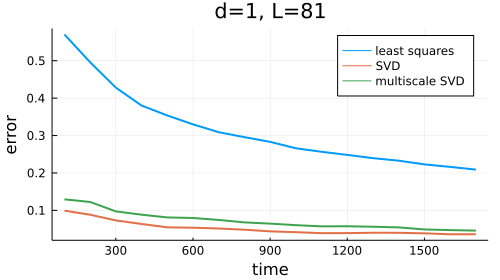

In [44]:
graph_experiment(lossEvery,errFs, errSVDs, errMultiSVDs, title="d=1, L=81")